In [1]:
import melanoma as mel

%matplotlib inline
%load_ext autoreload
%autoreload -p 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

rootpath = '/hpcstor6/scratch01/s/sanghyuk.kim001'
# img_size = (224, 224) # height, width
img_size = (150, 150) # height, width
utilInstance = mel.Util(rootpath, img_size)
dataType = mel.DatasetType.ISIC2016
networkType = mel.NetworkType.Xception


CREATE_DB = 0
# Save datasets as pickle files
if (CREATE_DB == 1):
    utilInstance.saveDatasetsToFile(dataType, networkType, 1.2)



2024-01-10 15:02:58.904479: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import EarlyStopping

img_height, img_width = utilInstance.getImgSize()

optimizer1 = Adam(lr=0.001)
optimizer2 = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
red_lr= ReduceLROnPlateau(monitor='val_accuracy', patience=3 , verbose=1, factor=0.7)
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 20)

CFG = dict(
			batch_size            =  64,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
			epochs                =  20,   # 5; 10; 20;
			last_trainable_layers =   0,
			verbose               =   1,   # 0; 1
			fontsize              =  14,
			num_classes           =  2, # binary

			# Images sizes
			img_height = img_height,   # Original: (450h, 600w)
            img_width = img_width,

			# Images augs
			ROTATION_RANGE        =   90.0,
			ZOOM_RANGE            =   0.1,
			HSHIFT_RANGE          =   0.1, # randomly shift images horizontally
			WSHIFT_RANGE          =   0.1, # randomly shift images vertically
			HFLIP                 = False, # randomly flip images
			VFLIP                 = False, # randomly flip images

			# Model settings
			pretrained_weights = 'imagenet',
			model_optimizer = optimizer2,
			# loss='binary_crossentropy',
			loss='categorical_crossentropy',
			metrics=['accuracy'],
			callbacks = [],

			# Postprocessing
			stopper_patience      =  0,   # 0.01; 0.05; 0.1; 0.2;
			# run_functions_eagerly = False,
            
            # save
            snapshot_path = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot'
		)
base_model = mel.CNN(CFG=CFG)

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Reloading 'melanoma.preprocess'.
Reloading 'melanoma.util'.
Reloading 'melanoma'.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
______________________________________

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
125/125 [==============================] - 4s 32ms/step - loss: 0.4188 - accuracy: 0.8277 - val_loss: 0.2144 - val_accuracy: 0.9502
Epoch 3/20
125/125 [==============================] - 4s 31ms/step - loss: 0.3546 - accuracy: 0.8573 - val_loss: 0.1602 - val_accuracy: 0.9660
Epoch 4/20
125/125 [==============================] - 4s 32ms/step - loss: 0.3192 - accuracy: 0.8731 - val_loss: 0.1704 - val_accuracy: 0.9558
Epoch 5/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2790 - accuracy: 0.8891 - val_loss: 0.1514 - val_accuracy: 0.9490
Epoch 6/20
125/125 [==============================] - 4s 31ms/step - loss: 0.2603 - accuracy: 0.8963 - val_loss: 0.1376 - val_accuracy: 0.9558
Epoch 7/20
125/125 [==============================] - 4s 32ms/step - loss: 0.2447 - accuracy: 0.9002 - val_loss: 0.1499 - val_accuracy: 0.9547
Epoch 8/20
125/125 [==============================] - 4s 32ms/step - loss: 0.2154 - accuracy: 0.9144 - val_loss: 0.1394 - val_accuracy: 0.9570

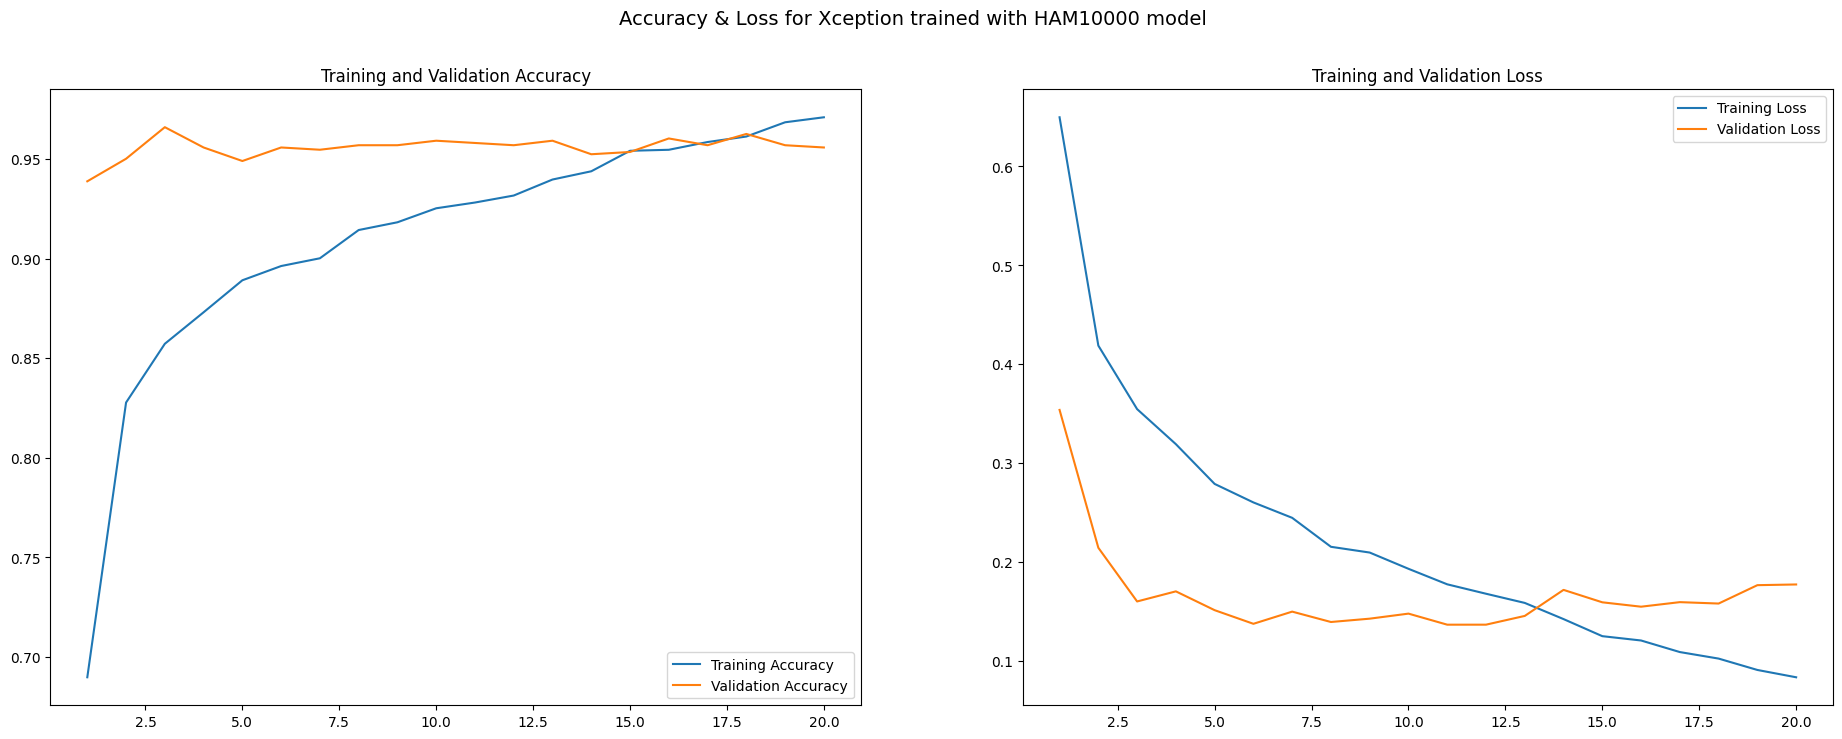

In [6]:
# Solely training HAM10000 with Xception
networkType = mel.NetworkType.Xception
dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages_HAM10000_augmented, testimages_HAM10000, validationimages_HAM10000, \
			trainlabels_binary_HAM10000_augmented, testlabels_binary_HAM10000, validationlabels_binary_HAM10000, num_classes_binary_HAM10000\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+'HAM10000_150h_150w_binary.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with HAM10000'
model = base_model.xception()

# Train HAM10000
history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages_HAM10000_augmented,
    trainlabels = trainlabels_binary_HAM10000_augmented,
    validationimages = validationimages_HAM10000,
    validationlabels = validationlabels_binary_HAM10000,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with HAM10000 model...



52/52 [==============================] - 2s 17ms/step - loss: 1.2411 - accuracy: 0.6591
Train loss = 1.2410812377929688  ;  Train accuracy = 65.91%

32/32 [==============================] - 1s 17ms/step - loss: 1.2399 - accuracy: 0.6580
Validation loss = 1.2398864030838013  ;  Validation accuracy = 65.80%

21/21 [==============================] - 0s 16ms/step - loss: 1.1404 - accuracy: 0.6515
Test loss = 1.1404181718826294  ;  Test accuracy = 65.15%
Computing predictions for Testing Kaggle DB on Xception trained with HAM10000...
Model report for Testing Kaggle DB on Xception trained with HAM10000 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.62      1.00      0.76       903
   Malignant       0.98      0.25      0.39       734

    accuracy                           0.66      1637
   macro avg       0.80      0.62      0.58      1637
weighted avg       0.78      0.66      0.60      1637

Test Report :
               precision    

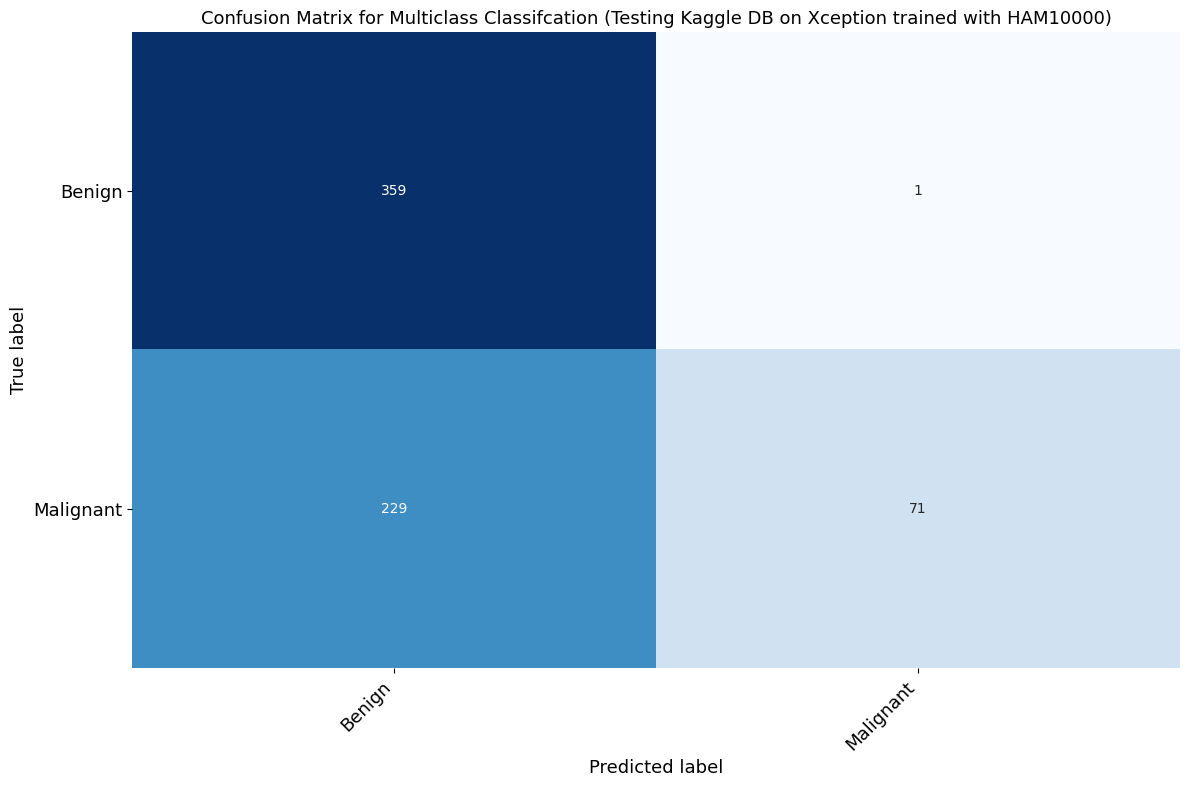

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with HAM10000 model...



251/251 [==============================] - 5s 16ms/step - loss: 0.1199 - accuracy: 0.9527
Train loss = 0.11993155628442764  ;  Train accuracy = 95.27%

28/28 [==============================] - 1s 17ms/step - loss: 0.1367 - accuracy: 0.9581
Validation loss = 0.13668519258499146  ;  Validation accuracy = 95.81%

35/35 [==============================] - 1s 17ms/step - loss: 0.1580 - accuracy: 0.9483
Test loss = 0.15799464285373688  ;  Test accuracy = 94.83%
Computing predictions for Testing HAM10000 on Xception trained with HAM10000...
Model report for Testing HAM10000 on Xception trained with HAM10000 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.95      1.00      0.97      6994
   Malignant       0.97      0.65      0.78      1035

    accuracy                           0.95      8029
   macro avg       0.96      0.82      0.88      8029
weighted avg       0.95      0.95      0.95      8029

Test Report :
               precision 

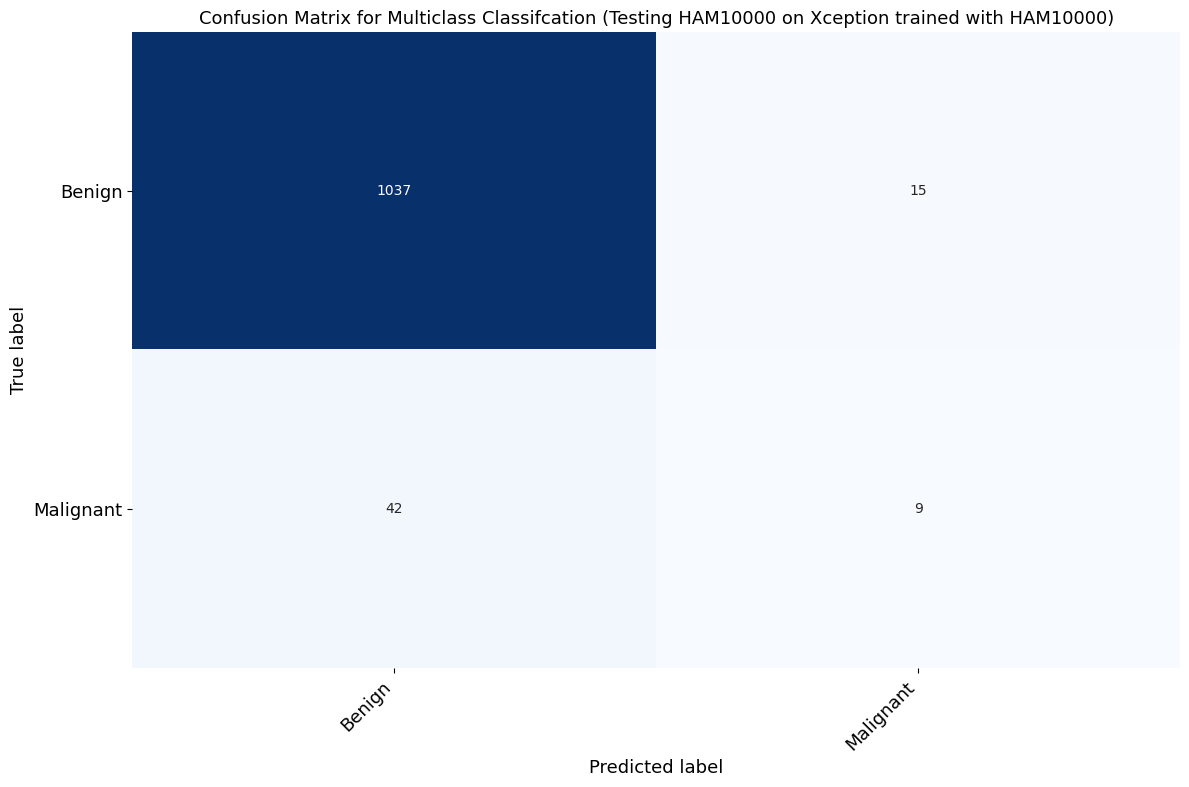

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with HAM10000 model...



23/23 [==============================] - 1s 17ms/step - loss: 0.6707 - accuracy: 0.8111
Train loss = 0.6706979274749756  ;  Train accuracy = 81.11%

6/6 [==============================] - 0s 15ms/step - loss: 0.6471 - accuracy: 0.8111
Validation loss = 0.6471495032310486  ;  Validation accuracy = 81.11%

12/12 [==============================] - 0s 16ms/step - loss: 0.6597 - accuracy: 0.8021
Test loss = 0.6596730351448059  ;  Test accuracy = 80.21%
Computing predictions for Testing ISIC2016 on Xception trained with HAM10000...
Model report for Testing ISIC2016 on Xception trained with HAM10000 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.83      0.97      0.89       583
   Malignant       0.52      0.12      0.20       137

    accuracy                           0.81       720
   macro avg       0.67      0.55      0.55       720
weighted avg       0.77      0.81      0.76       720

Test Report :
               precision    reca

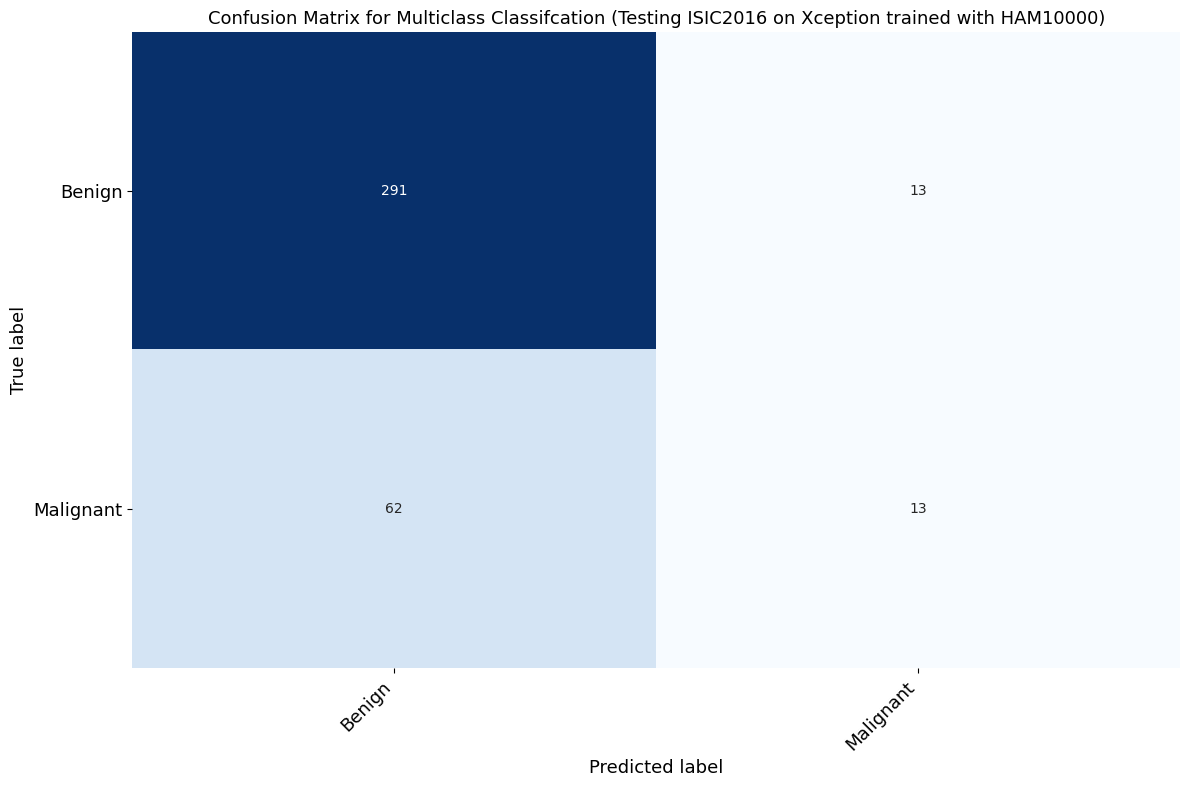

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with HAM10000 model...



63/63 [==============================] - 2s 16ms/step - loss: 0.7978 - accuracy: 0.8070
Train loss = 0.7978405952453613  ;  Train accuracy = 80.70%

5/5 [==============================] - 0s 15ms/step - loss: 0.9814 - accuracy: 0.8000
Validation loss = 0.9813835620880127  ;  Validation accuracy = 80.00%

19/19 [==============================] - 0s 15ms/step - loss: 0.9572 - accuracy: 0.7833
Test loss = 0.9572328925132751  ;  Test accuracy = 78.33%
Computing predictions for Testing ISIC2017 on Xception trained with HAM10000...
Model report for Testing ISIC2017 on Xception trained with HAM10000 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.82      0.97      0.89      1626
   Malignant       0.42      0.09      0.15       374

    accuracy                           0.81      2000
   macro avg       0.62      0.53      0.52      2000
weighted avg       0.75      0.81      0.75      2000

Test Report :
               precision    reca

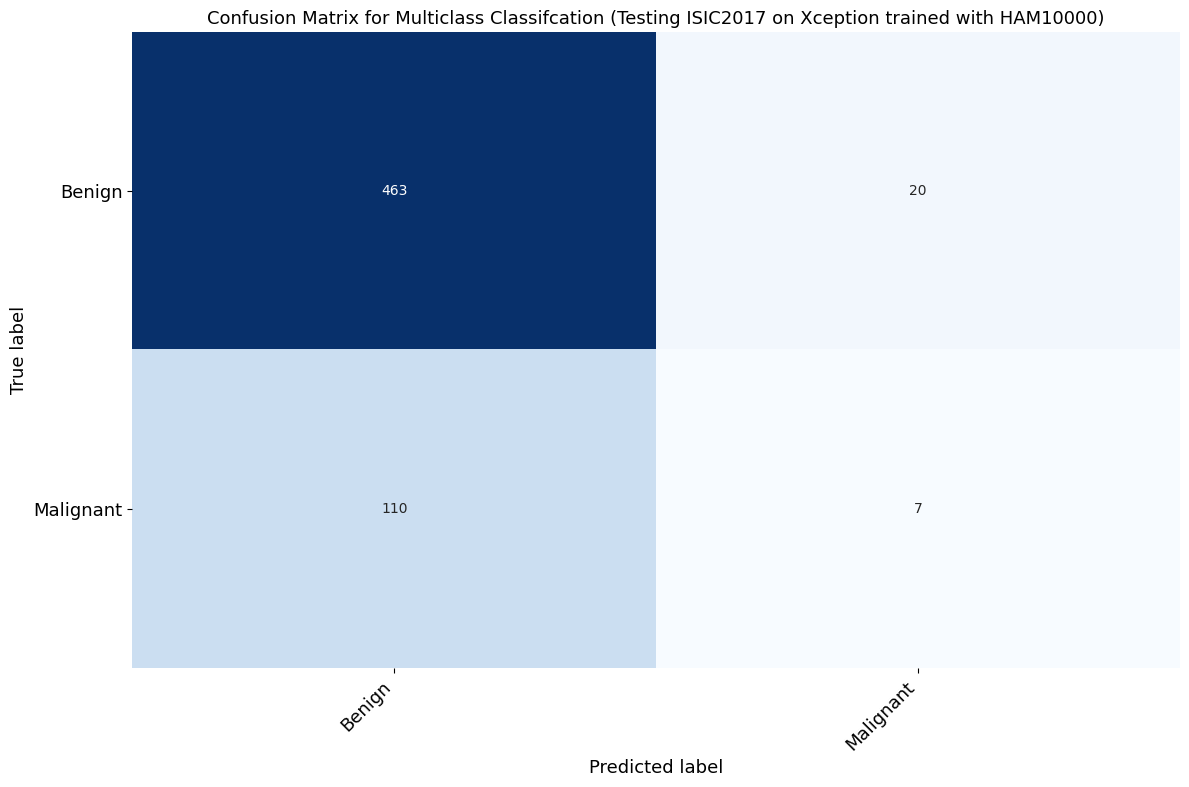

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with HAM10000 model...



313/313 [==============================] - 6s 18ms/step - loss: 0.1256 - accuracy: 0.9527
Train loss = 0.12560084462165833  ;  Train accuracy = 95.27%

7/7 [==============================] - 1s 82ms/step - loss: 0.3251 - accuracy: 0.8808
Validation loss = 0.32513242959976196  ;  Validation accuracy = 88.08%

48/48 [==============================] - 1s 15ms/step - loss: 0.3371 - accuracy: 0.8882
Test loss = 0.3371402323246002  ;  Test accuracy = 88.82%
Computing predictions for Testing ISIC2018 on Xception trained with HAM10000...
Model report for Testing ISIC2018 on Xception trained with HAM10000 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.95      0.99      0.97      8902
   Malignant       0.94      0.61      0.74      1113

    accuracy                           0.95     10015
   macro avg       0.95      0.80      0.86     10015
weighted avg       0.95      0.95      0.95     10015

Test Report :
               precision    

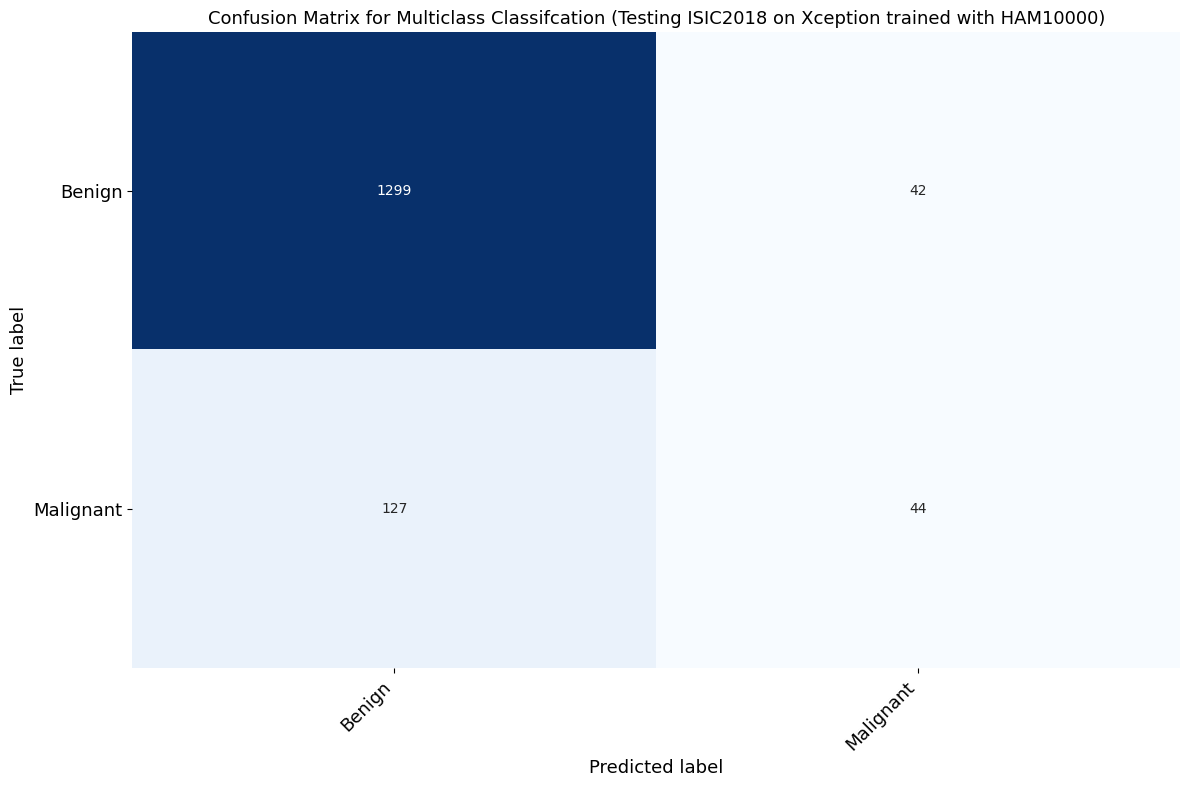

In [9]:

filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)              

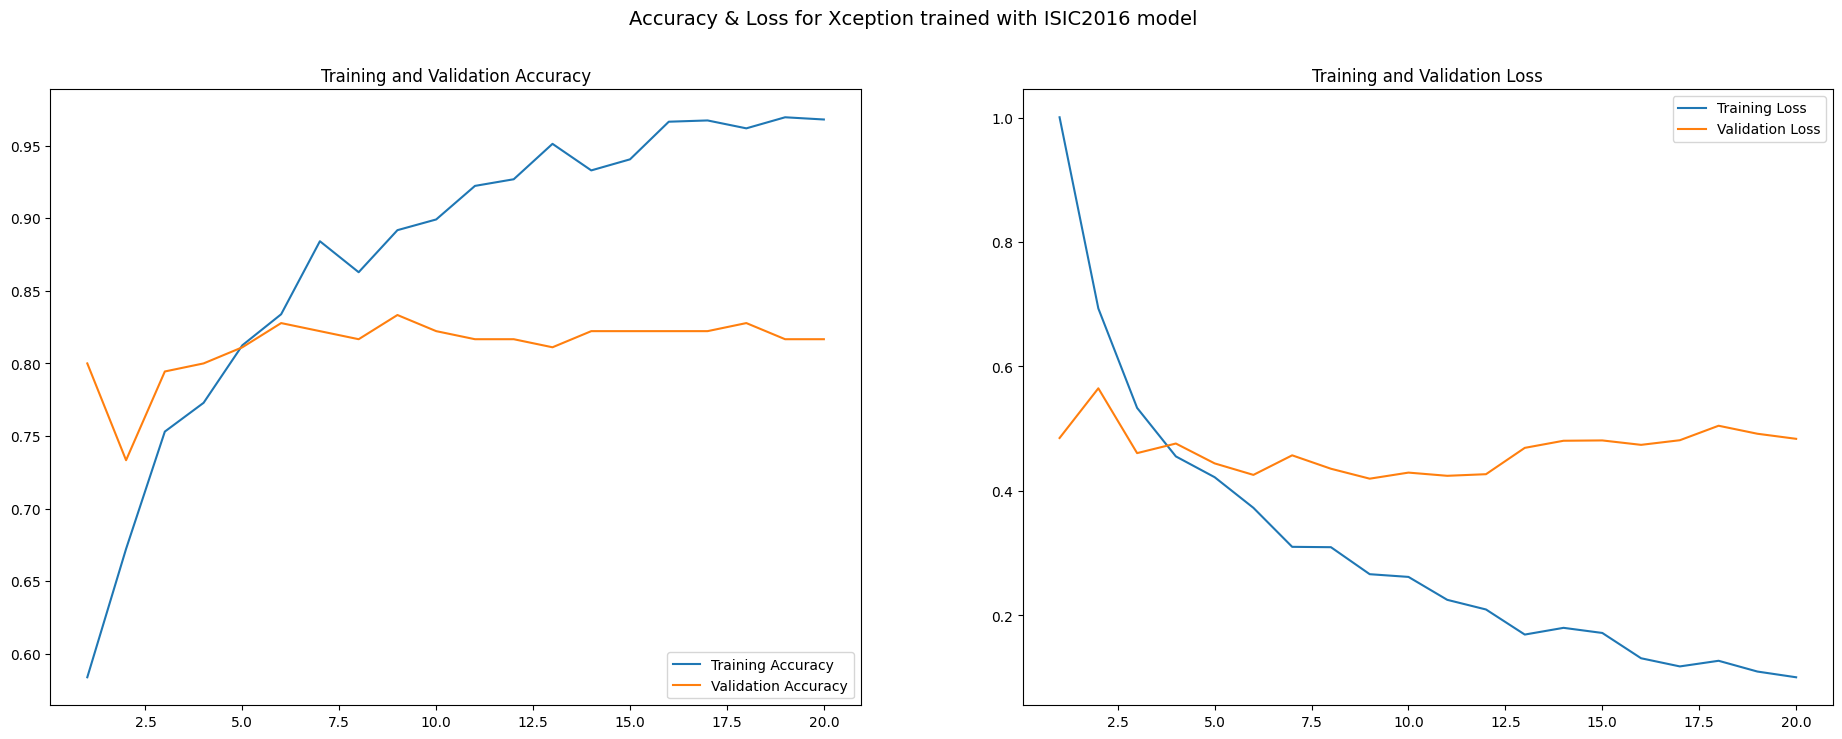

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2016 model...



52/52 [==============================] - 1s 17ms/step - loss: 0.8387 - accuracy: 0.6011
Train loss = 0.8387076258659363  ;  Train accuracy = 60.11%

32/32 [==============================] - 1s 17ms/step - loss: 0.9160 - accuracy: 0.5730
Validation loss = 0.9159913659095764  ;  Validation accuracy = 57.30%

21/21 [==============================] - 0s 16ms/step - loss: 0.8845 - accuracy: 0.5788
Test loss = 0.8845146298408508  ;  Test accuracy = 57.88%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2016...
Model report for Testing Kaggle DB on Xception trained with ISIC2016 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.58      0.99      0.73       903
   Malignant       0.93      0.12      0.21       734

    accuracy                           0.60      1637
   macro avg       0.75      0.56      0.47      1637
weighted avg       0.74      0.60      0.50      1637

Test Report :
               precision    

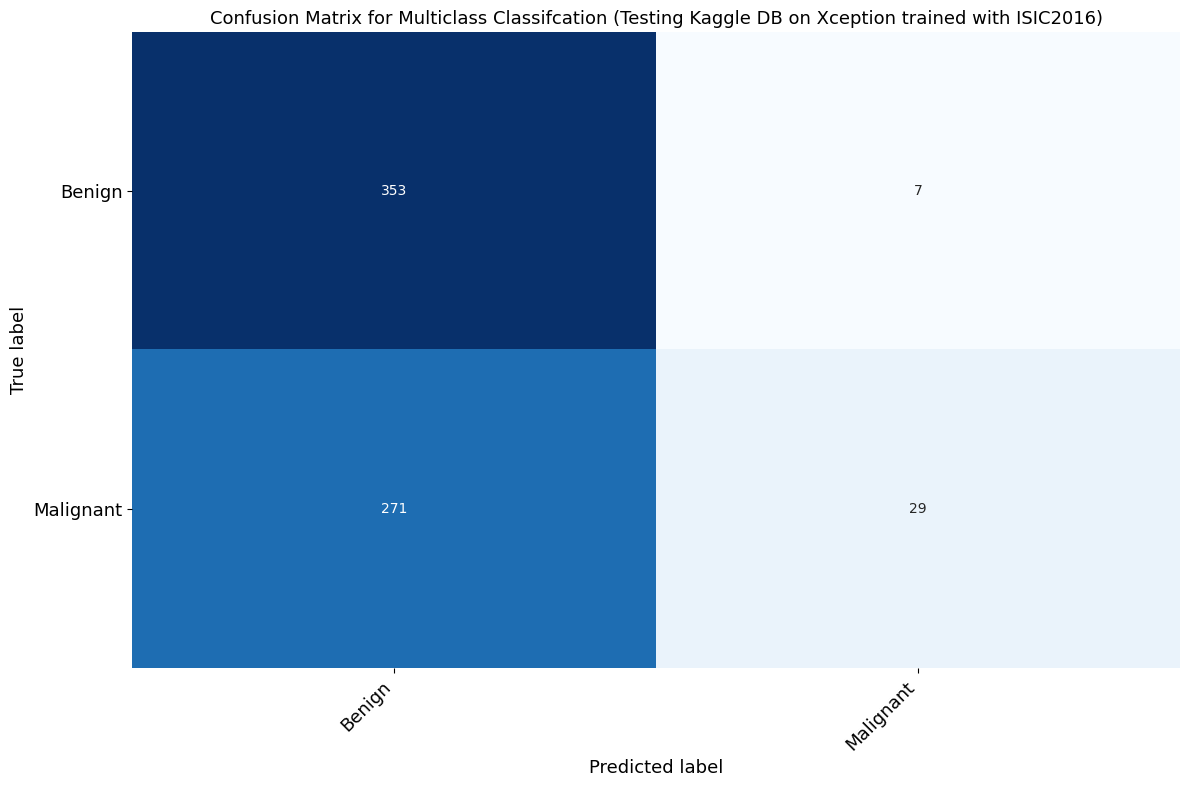

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2016 model...



251/251 [==============================] - 5s 17ms/step - loss: 0.4242 - accuracy: 0.8377
Train loss = 0.42423635721206665  ;  Train accuracy = 83.77%

28/28 [==============================] - 0s 15ms/step - loss: 0.2480 - accuracy: 0.9400
Validation loss = 0.24804051220417023  ;  Validation accuracy = 94.00%

35/35 [==============================] - 1s 16ms/step - loss: 0.2548 - accuracy: 0.9383
Test loss = 0.25480303168296814  ;  Test accuracy = 93.83%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2016...
Model report for Testing HAM10000 on Xception trained with ISIC2016 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.88      0.95      0.91      6994
   Malignant       0.21      0.09      0.13      1035

    accuracy                           0.84      8029
   macro avg       0.54      0.52      0.52      8029
weighted avg       0.79      0.84      0.81      8029

Test Report :
               precision 

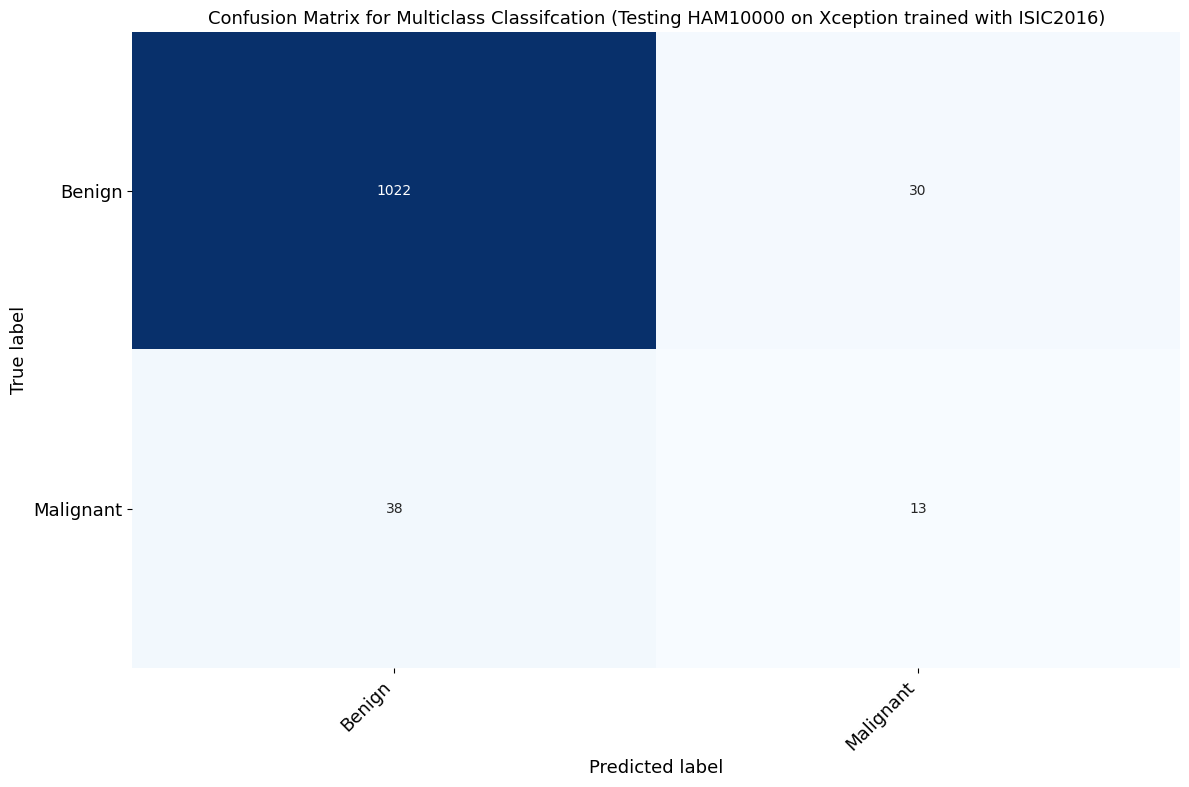

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2016 model...



23/23 [==============================] - 1s 17ms/step - loss: 0.2137 - accuracy: 0.9056
Train loss = 0.2136787474155426  ;  Train accuracy = 90.56%

6/6 [==============================] - 0s 16ms/step - loss: 0.4198 - accuracy: 0.8333
Validation loss = 0.41976043581962585  ;  Validation accuracy = 83.33%

12/12 [==============================] - 0s 16ms/step - loss: 0.4394 - accuracy: 0.8232
Test loss = 0.43938925862312317  ;  Test accuracy = 82.32%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2016...
Model report for Testing ISIC2016 on Xception trained with ISIC2016 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.90      1.00      0.94       583
   Malignant       1.00      0.50      0.67       137

    accuracy                           0.91       720
   macro avg       0.95      0.75      0.81       720
weighted avg       0.92      0.91      0.89       720

Test Report :
               precision    re

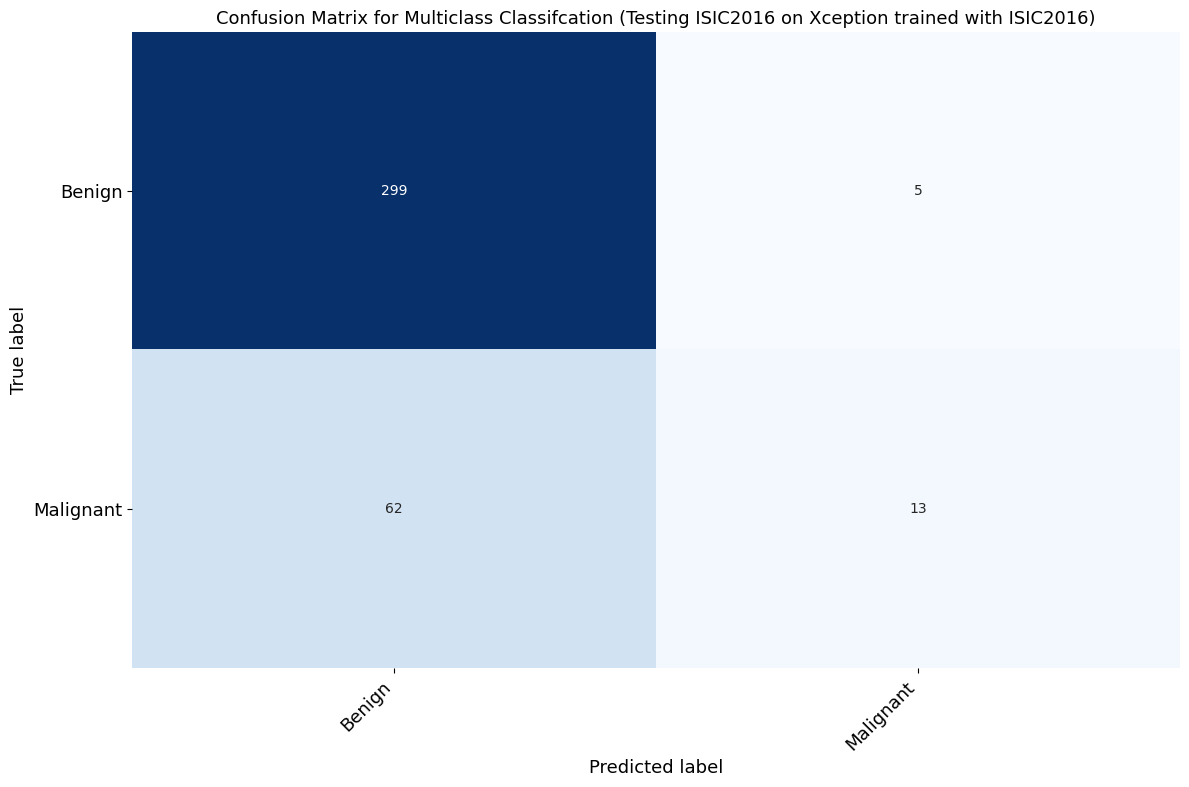

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2016 model...



63/63 [==============================] - 2s 19ms/step - loss: 0.4180 - accuracy: 0.8385
Train loss = 0.4179840087890625  ;  Train accuracy = 83.85%

5/5 [==============================] - 0s 15ms/step - loss: 0.5497 - accuracy: 0.7933
Validation loss = 0.5497163534164429  ;  Validation accuracy = 79.33%

19/19 [==============================] - 0s 16ms/step - loss: 0.5426 - accuracy: 0.7983
Test loss = 0.5426181554794312  ;  Test accuracy = 79.83%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2016...
Model report for Testing ISIC2017 on Xception trained with ISIC2016 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.84      0.98      0.91      1626
   Malignant       0.74      0.21      0.33       374

    accuracy                           0.84      2000
   macro avg       0.79      0.60      0.62      2000
weighted avg       0.82      0.84      0.80      2000

Test Report :
               precision    reca

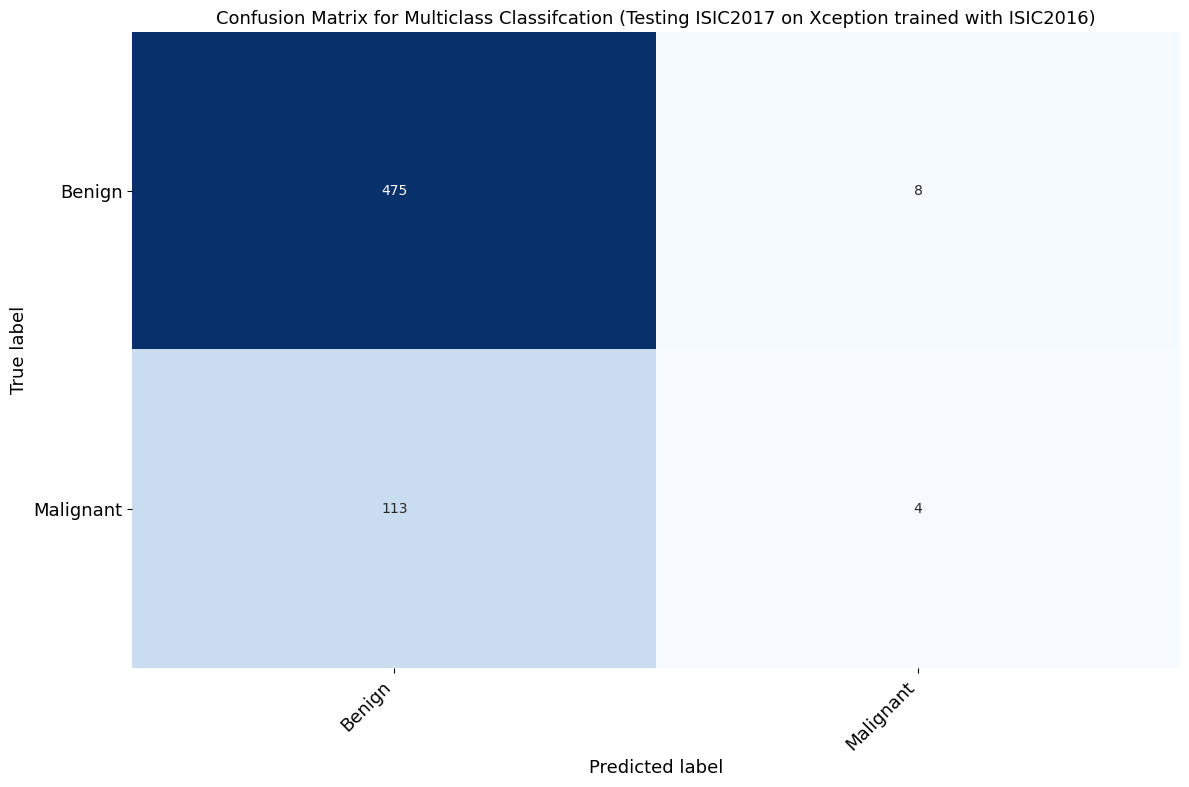

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2016 model...



313/313 [==============================] - 5s 16ms/step - loss: 0.3900 - accuracy: 0.8578
Train loss = 0.39004090428352356  ;  Train accuracy = 85.78%

7/7 [==============================] - 0s 14ms/step - loss: 0.4187 - accuracy: 0.8446
Validation loss = 0.41869187355041504  ;  Validation accuracy = 84.46%

48/48 [==============================] - 1s 18ms/step - loss: 0.3994 - accuracy: 0.8479
Test loss = 0.3994123339653015  ;  Test accuracy = 84.79%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2016...
Model report for Testing ISIC2018 on Xception trained with ISIC2016 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.89      0.95      0.92      8902
   Malignant       0.21      0.10      0.14      1113

    accuracy                           0.86     10015
   macro avg       0.55      0.53      0.53     10015
weighted avg       0.82      0.86      0.84     10015

Test Report :
               precision    

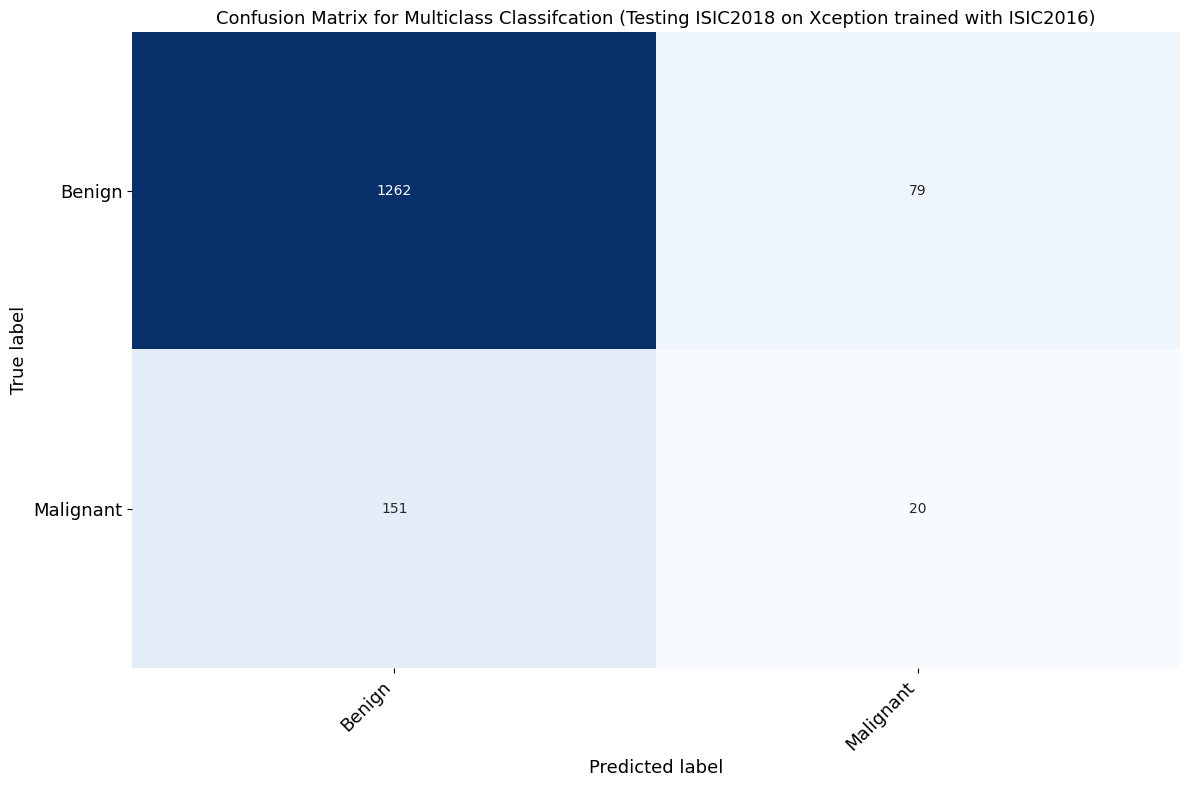

In [11]:
# Solely training ISIC2016 with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+'ISIC2016_150h_150w_binary.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ISIC2016'
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
31/31 [==============================] - 1s 30ms/step - loss: 0.5772 - accuracy: 0.7123 - val_loss: 0.4691 - val_accuracy: 0.8000
Epoch 3/20
31/31 [==============================] - 1s 29ms/step - loss: 0.4920 - accuracy: 0.7655 - val_loss: 0.4693 - val_accuracy: 0.8067
Epoch 4/20
31/31 [==============================] - 1s 32ms/step - loss: 0.4152 - accuracy: 0.8151 - val_loss: 0.4790 - val_accuracy: 0.8133
Epoch 5/20
31/31 [==============================] - 1s 31ms/step - loss: 0.3692 - accuracy: 0.8419 - val_loss: 0.4606 - val_accuracy: 0.8067
Epoch 6/20
31/31 [==============================] - 1s 30ms/step - loss: 0.3215 - accuracy: 0.8729 - val_loss: 0.4770 - val_accuracy: 0.8000
Epoch 7/20
31/31 [==============================] - 1s 30ms/step - loss: 0.2923 - accuracy: 0.8931 - val_loss: 0.4766 - val_accuracy: 0.8000
Epoch 8/20
31/31 [==============================] - 1s 29ms/step - loss: 0.2694 - accuracy: 0.8941 - val_loss: 0.4632 - val_accuracy: 0.8267
Epoch 9/20
31

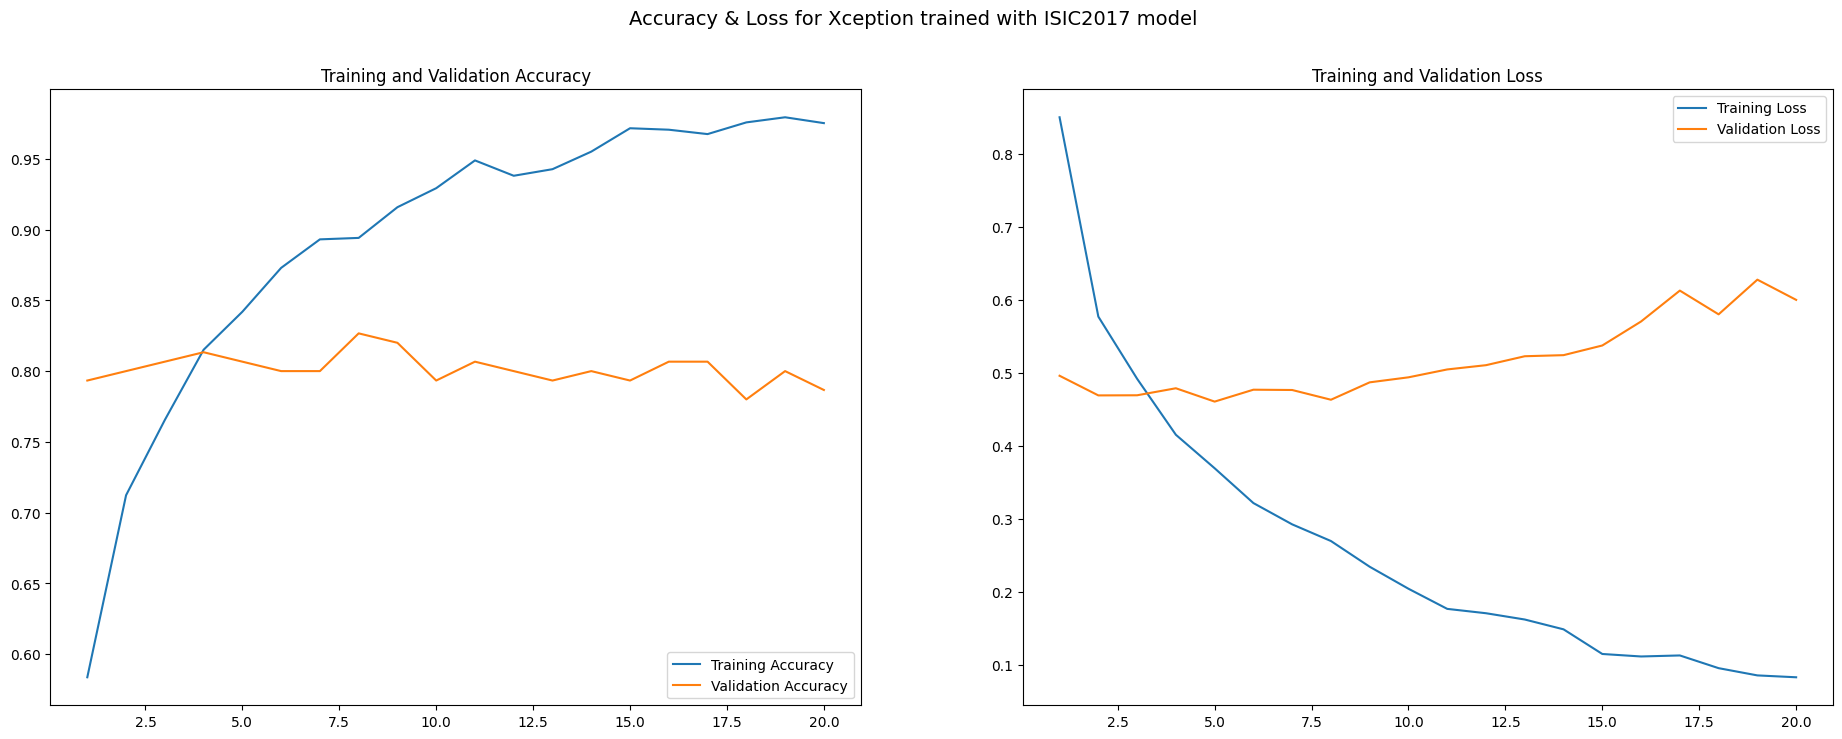

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2017 model...



52/52 [==============================] - 2s 16ms/step - loss: 0.7247 - accuracy: 0.6151
Train loss = 0.7247073650360107  ;  Train accuracy = 61.51%

32/32 [==============================] - 1s 15ms/step - loss: 0.7468 - accuracy: 0.6010
Validation loss = 0.7468460202217102  ;  Validation accuracy = 60.10%

21/21 [==============================] - 0s 16ms/step - loss: 0.6993 - accuracy: 0.6167
Test loss = 0.6993001699447632  ;  Test accuracy = 61.67%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2017...
Model report for Testing Kaggle DB on Xception trained with ISIC2017 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.59      0.95      0.73       903
   Malignant       0.77      0.20      0.32       734

    accuracy                           0.62      1637
   macro avg       0.68      0.58      0.53      1637
weighted avg       0.67      0.62      0.55      1637

Test Report :
               precision    

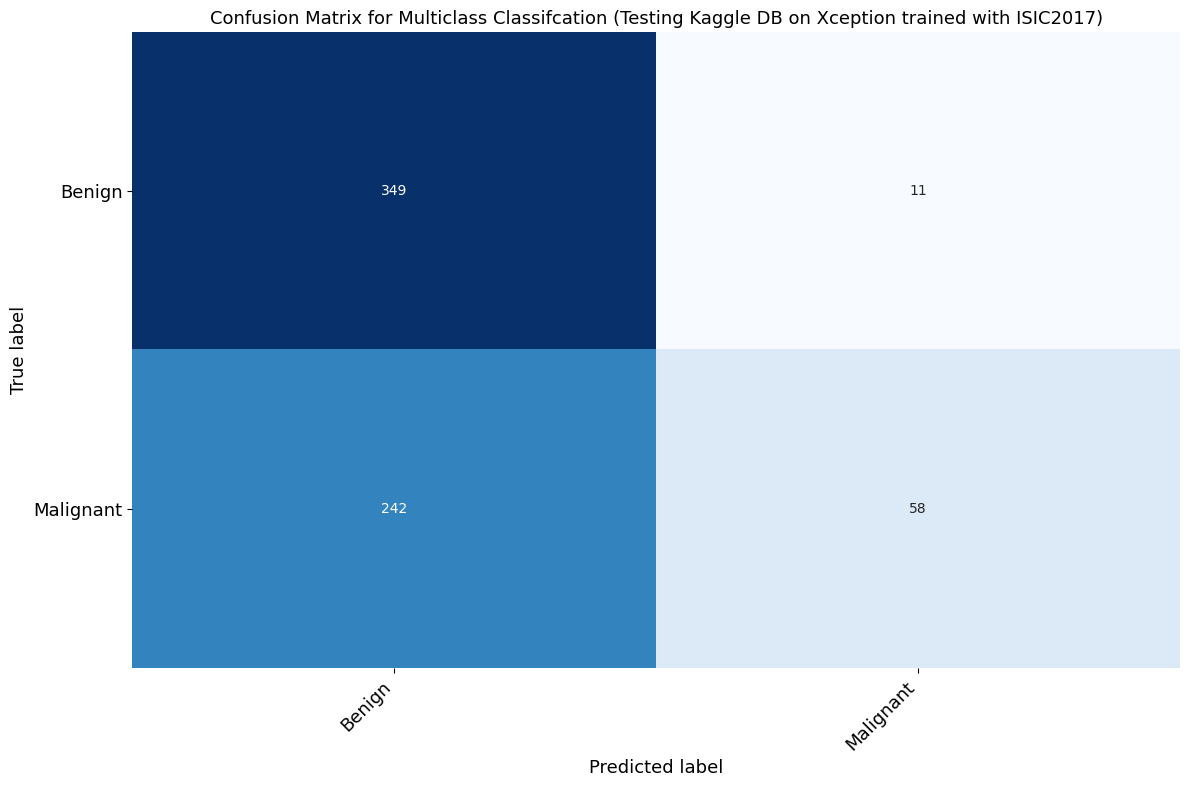

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2017 model...



251/251 [==============================] - 4s 16ms/step - loss: 0.4655 - accuracy: 0.8202
Train loss = 0.46548956632614136  ;  Train accuracy = 82.02%

28/28 [==============================] - 0s 16ms/step - loss: 0.3591 - accuracy: 0.9060
Validation loss = 0.3591134548187256  ;  Validation accuracy = 90.60%

35/35 [==============================] - 1s 16ms/step - loss: 0.3644 - accuracy: 0.8957
Test loss = 0.36438435316085815  ;  Test accuracy = 89.57%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2017...
Model report for Testing HAM10000 on Xception trained with ISIC2017 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.88      0.92      0.90      6994
   Malignant       0.20      0.13      0.16      1035

    accuracy                           0.82      8029
   macro avg       0.54      0.53      0.53      8029
weighted avg       0.79      0.82      0.80      8029

Test Report :
               precision  

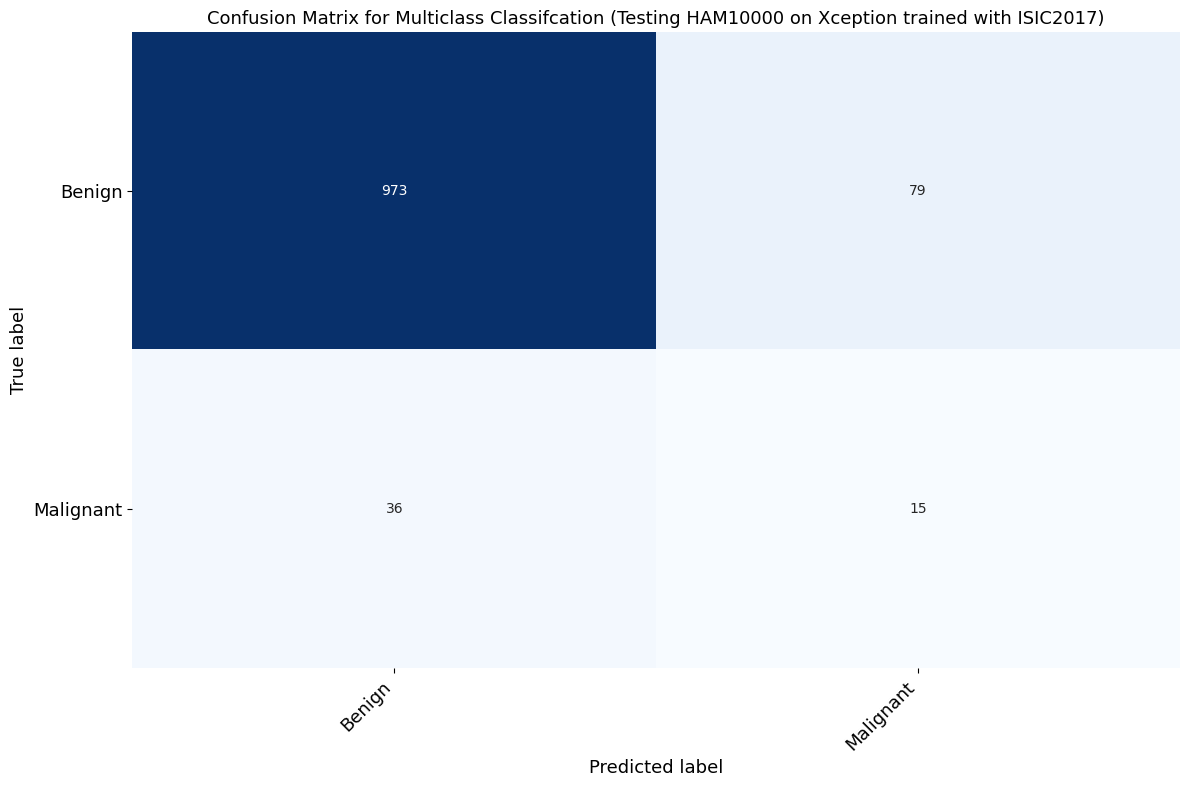

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2017 model...



23/23 [==============================] - 1s 16ms/step - loss: 0.3144 - accuracy: 0.8694
Train loss = 0.3143959641456604  ;  Train accuracy = 86.94%

6/6 [==============================] - 0s 15ms/step - loss: 0.3039 - accuracy: 0.8944
Validation loss = 0.30389103293418884  ;  Validation accuracy = 89.44%

12/12 [==============================] - 0s 16ms/step - loss: 0.3131 - accuracy: 0.8760
Test loss = 0.3131420910358429  ;  Test accuracy = 87.60%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2017...
Model report for Testing ISIC2016 on Xception trained with ISIC2017 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.87      0.98      0.92       583
   Malignant       0.83      0.39      0.53       137

    accuracy                           0.87       720
   macro avg       0.85      0.69      0.73       720
weighted avg       0.87      0.87      0.85       720

Test Report :
               precision    rec

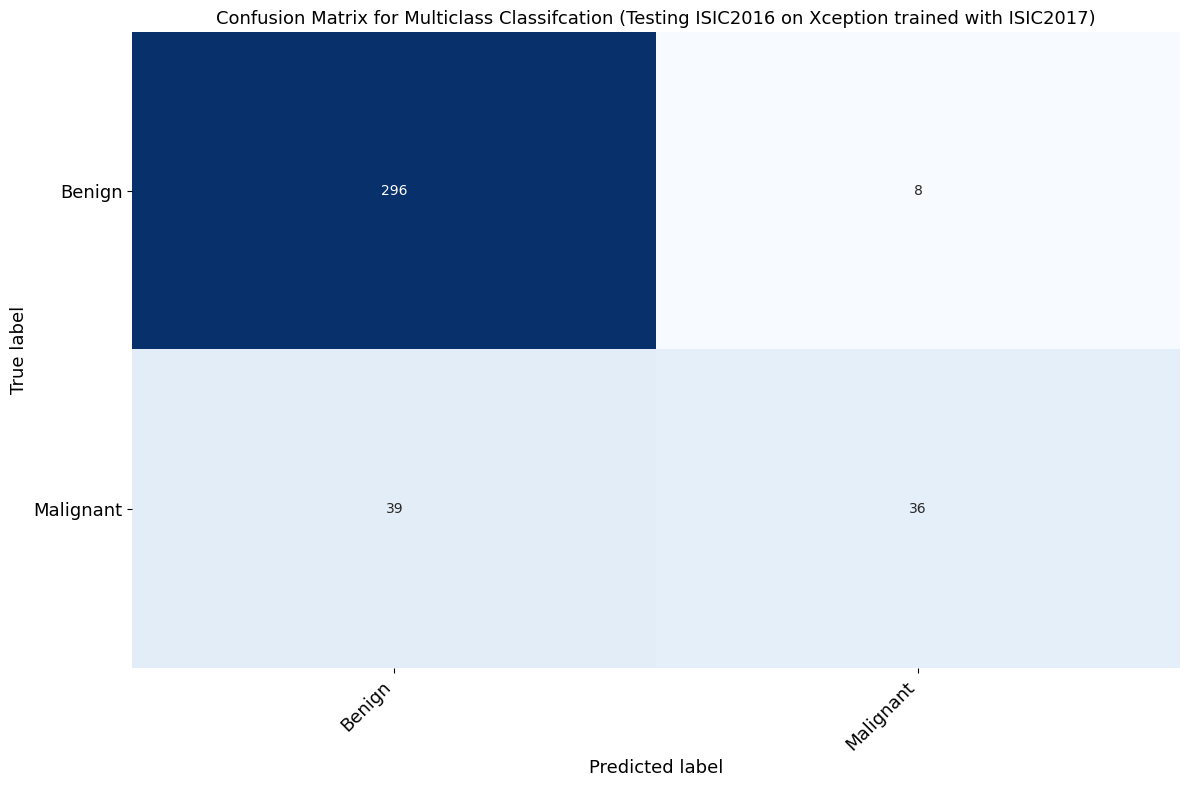

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2017 model...



63/63 [==============================] - 2s 16ms/step - loss: 0.2748 - accuracy: 0.8915
Train loss = 0.274845153093338  ;  Train accuracy = 89.15%

5/5 [==============================] - 0s 15ms/step - loss: 0.4606 - accuracy: 0.8067
Validation loss = 0.460649311542511  ;  Validation accuracy = 80.67%

19/19 [==============================] - 0s 16ms/step - loss: 0.4582 - accuracy: 0.8117
Test loss = 0.4582499563694  ;  Test accuracy = 81.17%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2017...
Model report for Testing ISIC2017 on Xception trained with ISIC2017 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.89      1.00      0.94      1626
   Malignant       0.95      0.44      0.60       374

    accuracy                           0.89      2000
   macro avg       0.92      0.72      0.77      2000
weighted avg       0.90      0.89      0.87      2000

Test Report :
               precision    recall  f

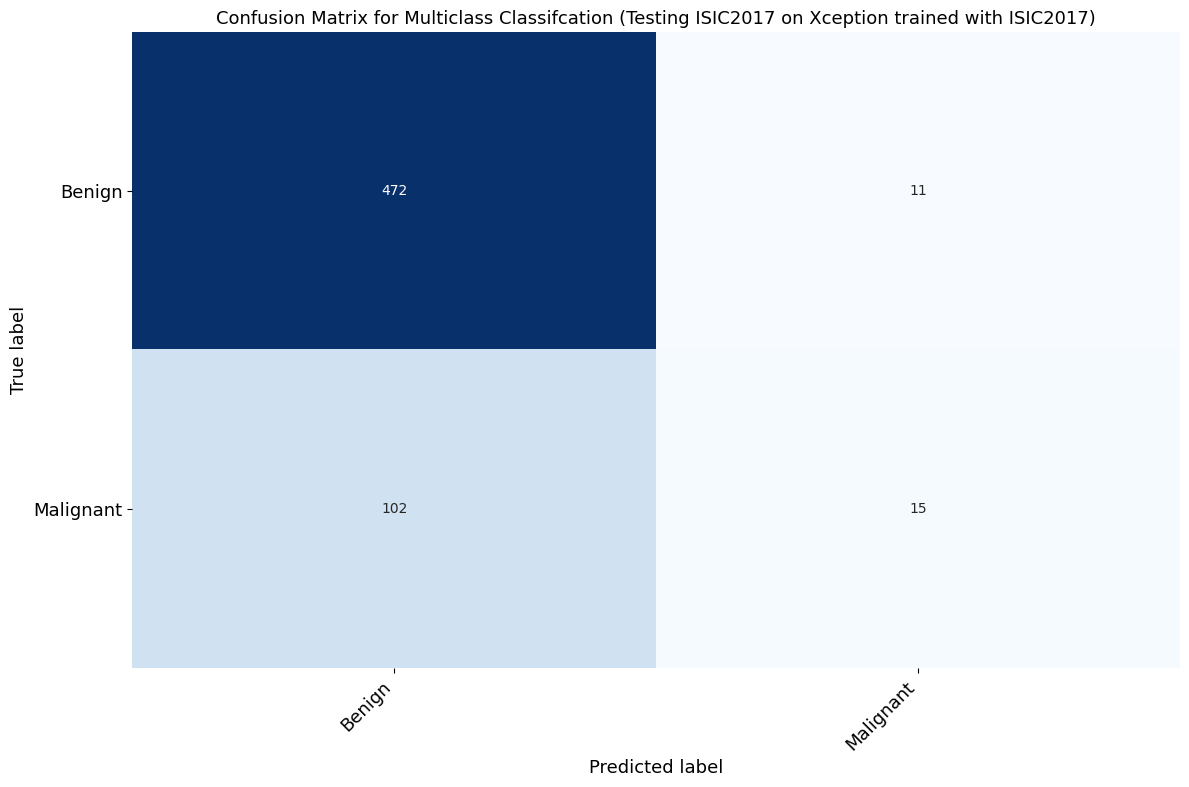

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2017 model...



313/313 [==============================] - 6s 16ms/step - loss: 0.4450 - accuracy: 0.8360
Train loss = 0.44497549533843994  ;  Train accuracy = 83.60%

7/7 [==============================] - 0s 14ms/step - loss: 0.4432 - accuracy: 0.8497
Validation loss = 0.44323205947875977  ;  Validation accuracy = 84.97%

48/48 [==============================] - 1s 17ms/step - loss: 0.4478 - accuracy: 0.8320
Test loss = 0.4478119909763336  ;  Test accuracy = 83.20%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2017...
Model report for Testing ISIC2018 on Xception trained with ISIC2017 model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.90      0.92      0.91      8902
   Malignant       0.19      0.14      0.16      1113

    accuracy                           0.84     10015
   macro avg       0.54      0.53      0.53     10015
weighted avg       0.82      0.84      0.83     10015

Test Report :
               precision    

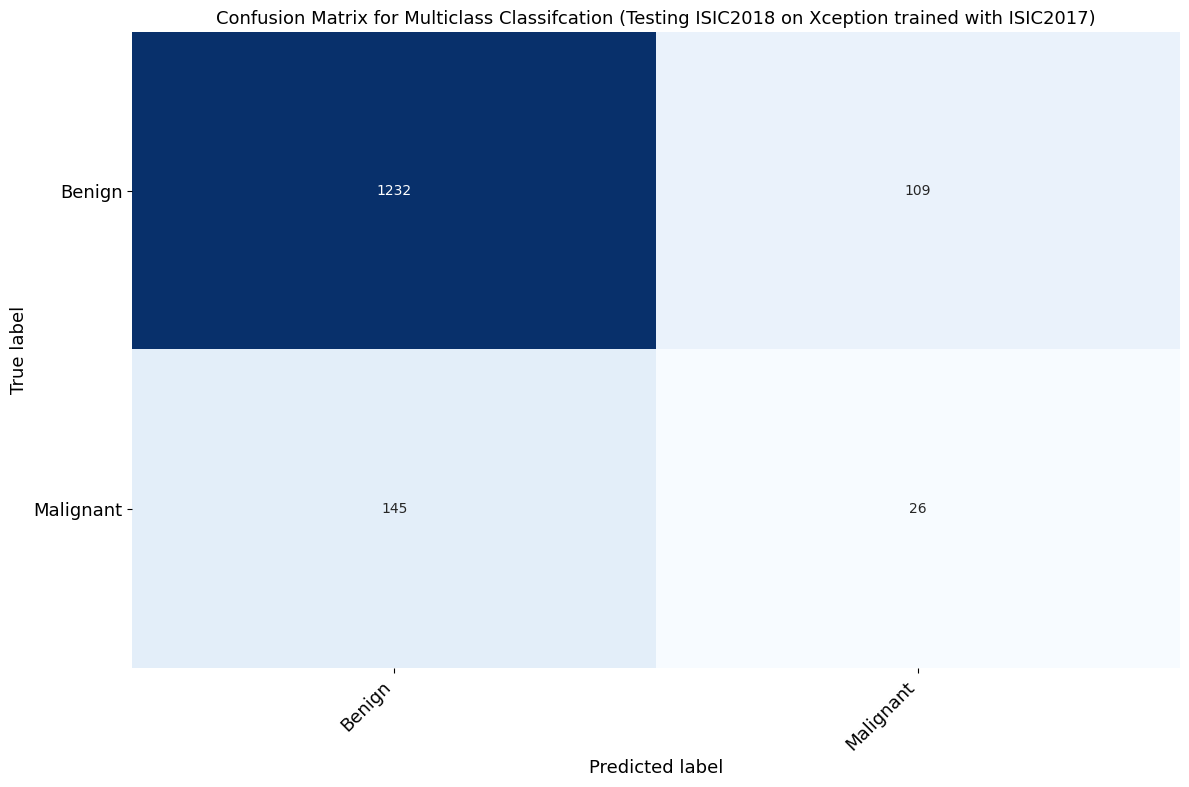

In [12]:
# Solely training ISIC2017 with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+'ISIC2017_150h_150w_binary.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ISIC2017'
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)              

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
65/65 [==============================] - 2s 31ms/step - loss: 0.4902 - accuracy: 0.7692 - val_loss: 0.4186 - val_accuracy: 0.8303
Epoch 3/20
65/65 [==============================] - 2s 32ms/step - loss: 0.4213 - accuracy: 0.8081 - val_loss: 0.3586 - val_accuracy: 0.8667
Epoch 4/20
65/65 [==============================] - 2s 30ms/step - loss: 0.3824 - accuracy: 0.8281 - val_loss: 0.3520 - val_accuracy: 0.8636
Epoch 5/20
65/65 [==============================] - 2s 34ms/step - loss: 0.3235 - accuracy: 0.8524 - val_loss: 0.3541 - val_accuracy: 0.8636
Epoch 6/20
65/65 [==============================] - 2s 30ms/step - loss: 0.2978 - accuracy: 0.8667 - val_loss: 0.3415 - val_accuracy: 0.8788
Epoch 7/20
65/65 [==============================] - 2s 30ms/step - loss: 0.2597 - accuracy: 0.8938 - val_loss: 0.3410 - val_accuracy: 0.8697
Epoch 8/20
65/65 [==============================] - 2s 30ms/step - loss: 0.2236 - accuracy: 0.9115 - val_loss: 0.3107 - val_accuracy: 0.8848
Epoch 9/20
65

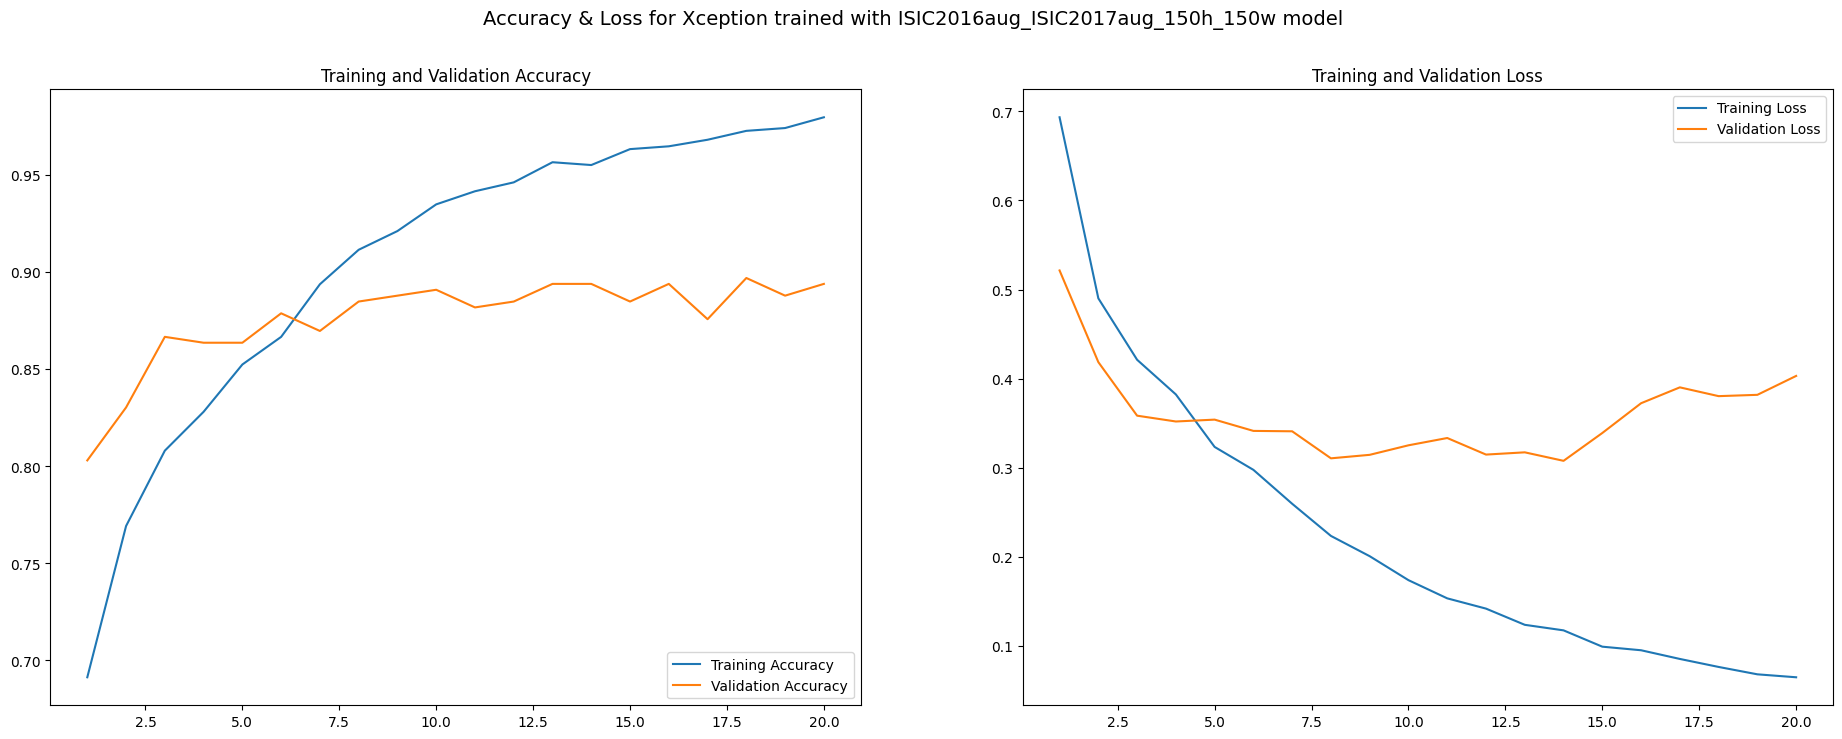

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model...



52/52 [==============================] - 2s 16ms/step - loss: 0.8898 - accuracy: 0.6854
Train loss = 0.8897648453712463  ;  Train accuracy = 68.54%

32/32 [==============================] - 1s 15ms/step - loss: 0.9916 - accuracy: 0.6710
Validation loss = 0.9915812611579895  ;  Validation accuracy = 67.10%

21/21 [==============================] - 0s 16ms/step - loss: 0.8840 - accuracy: 0.6652
Test loss = 0.8839518427848816  ;  Test accuracy = 66.52%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w...
Model report for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.67      0.86      0.75       903
   Malignant       0.73      0.47      0.57       734

    accuracy                           0.69      1637
   macro avg       0.70      0.67      0.66      1637
weighted avg       0.70      0.69      0.67    

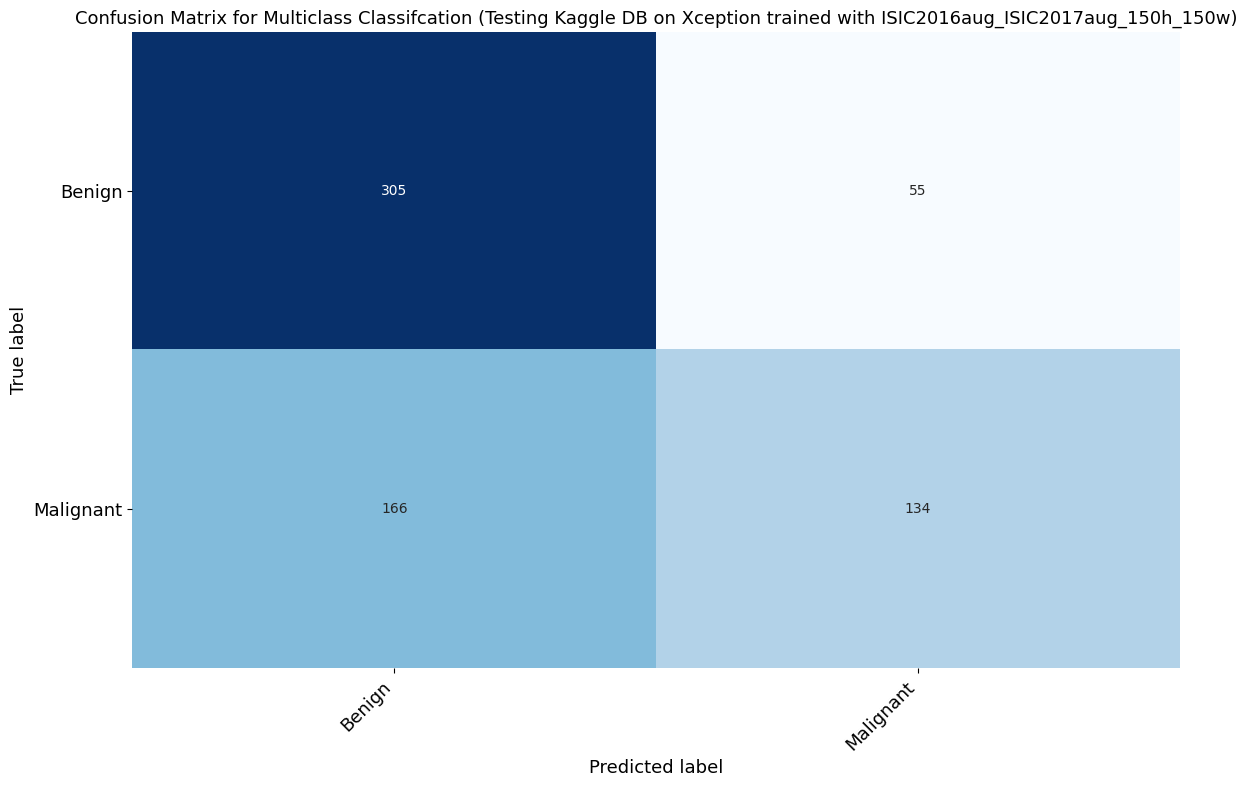

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model...



251/251 [==============================] - 4s 16ms/step - loss: 0.7224 - accuracy: 0.7436
Train loss = 0.7223957777023315  ;  Train accuracy = 74.36%

28/28 [==============================] - 0s 16ms/step - loss: 0.4986 - accuracy: 0.8029
Validation loss = 0.49863651394844055  ;  Validation accuracy = 80.29%

35/35 [==============================] - 1s 16ms/step - loss: 0.5031 - accuracy: 0.7924
Test loss = 0.5031365156173706  ;  Test accuracy = 79.24%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w...
Model report for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.88      0.81      0.85      6994
   Malignant       0.18      0.28      0.22      1035

    accuracy                           0.74      8029
   macro avg       0.53      0.55      0.53      8029
weighted avg       0.79      0.74      0.77   

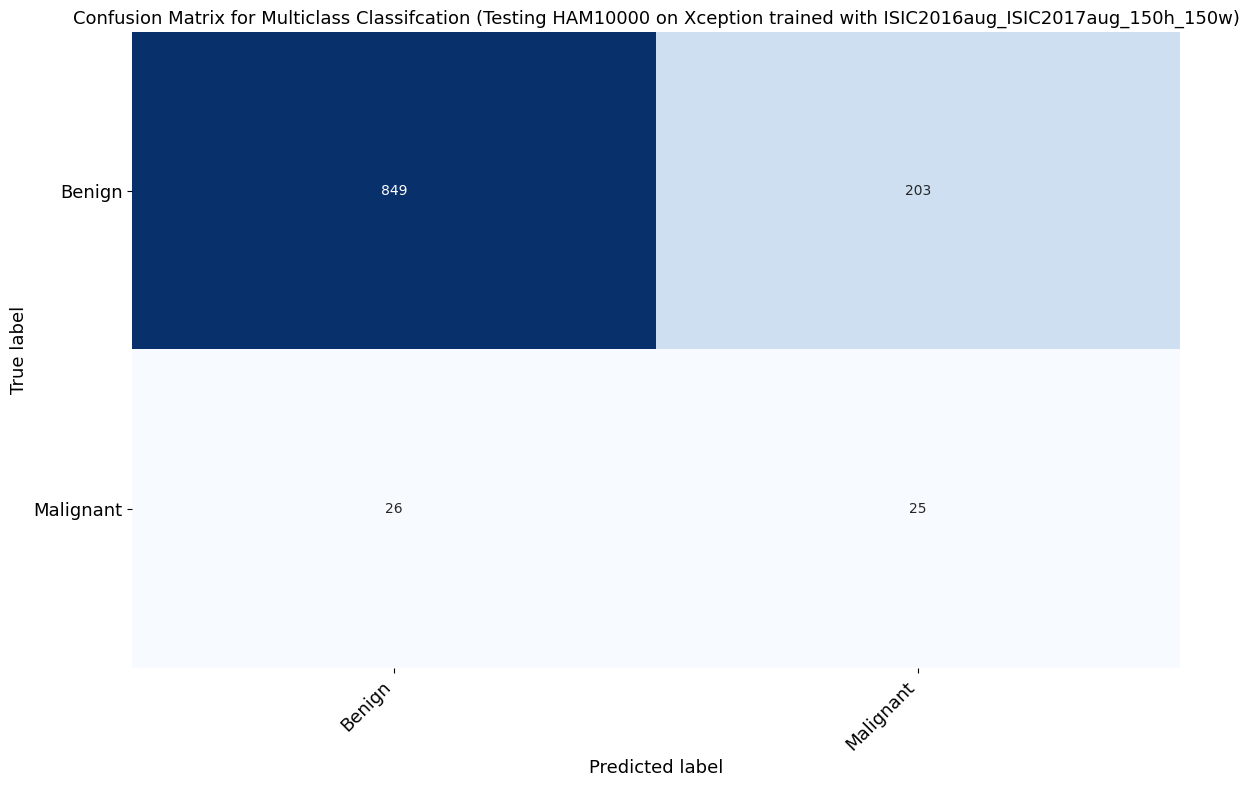

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model...



23/23 [==============================] - 1s 16ms/step - loss: 0.0316 - accuracy: 0.9972
Train loss = 0.03157152608036995  ;  Train accuracy = 99.72%

6/6 [==============================] - 0s 15ms/step - loss: 0.1403 - accuracy: 0.9500
Validation loss = 0.14030447602272034  ;  Validation accuracy = 95.00%

12/12 [==============================] - 0s 15ms/step - loss: 0.1586 - accuracy: 0.9446
Test loss = 0.1586407721042633  ;  Test accuracy = 94.46%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w...
Model report for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       583
   Malignant       0.99      0.99      0.99       137

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00      

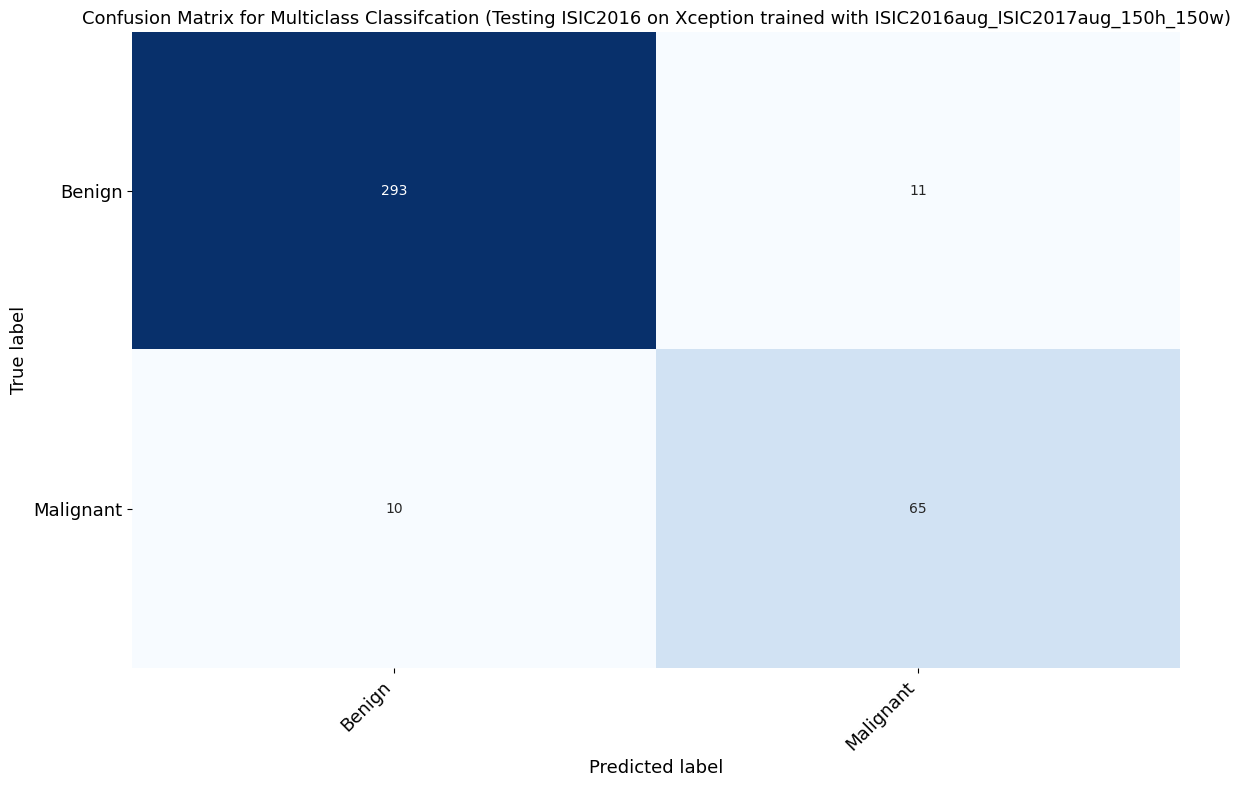

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model...



63/63 [==============================] - 2s 17ms/step - loss: 0.0388 - accuracy: 0.9925
Train loss = 0.03879310563206673  ;  Train accuracy = 99.25%

5/5 [==============================] - 0s 15ms/step - loss: 0.5090 - accuracy: 0.8267
Validation loss = 0.5090070366859436  ;  Validation accuracy = 82.67%

19/19 [==============================] - 0s 17ms/step - loss: 0.7497 - accuracy: 0.7683
Test loss = 0.7496832609176636  ;  Test accuracy = 76.83%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w...
Model report for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.99      1.00      1.00      1626
   Malignant       1.00      0.96      0.98       374

    accuracy                           0.99      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2

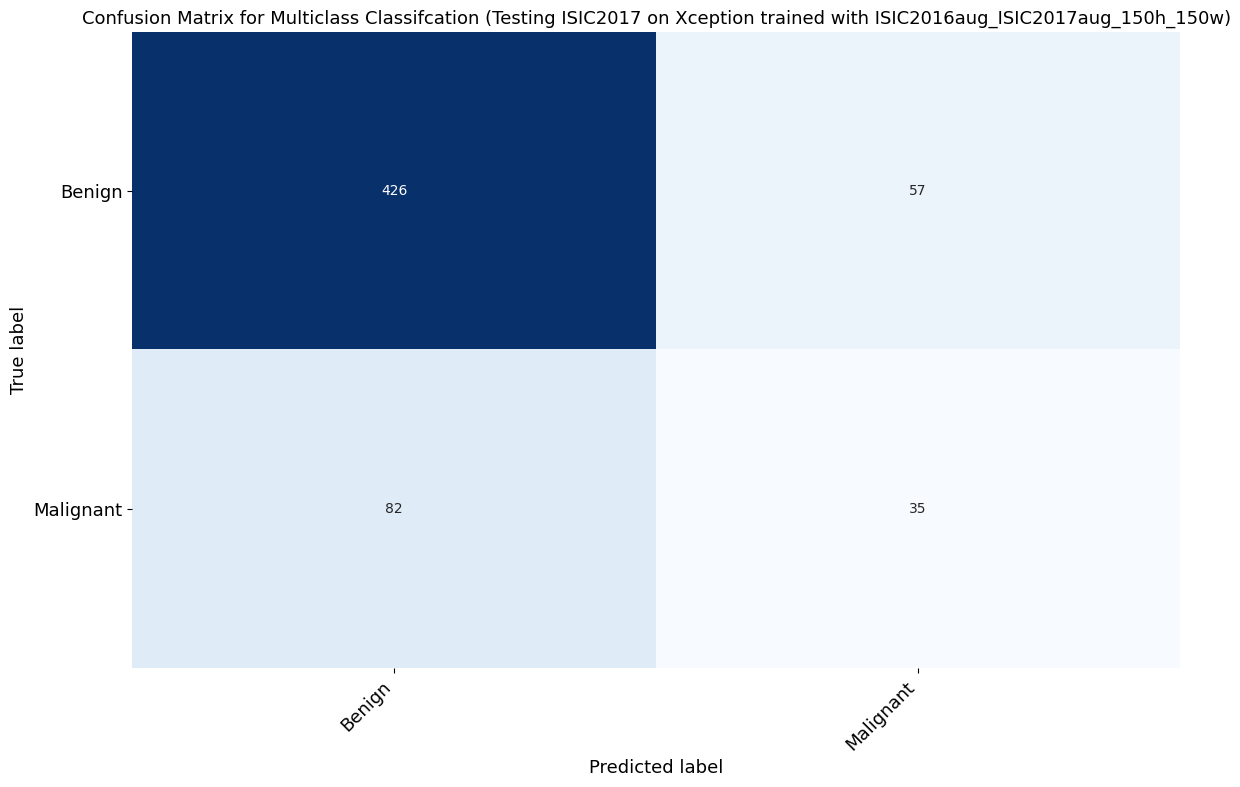

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model...



313/313 [==============================] - 6s 17ms/step - loss: 0.6785 - accuracy: 0.7542
Train loss = 0.6785191297531128  ;  Train accuracy = 75.42%

7/7 [==============================] - 0s 14ms/step - loss: 0.7819 - accuracy: 0.7306
Validation loss = 0.7819058895111084  ;  Validation accuracy = 73.06%

48/48 [==============================] - 1s 17ms/step - loss: 0.6849 - accuracy: 0.7454
Test loss = 0.6848787069320679  ;  Test accuracy = 74.54%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w...
Model report for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.90      0.81      0.85      8902
   Malignant       0.16      0.29      0.21      1113

    accuracy                           0.75     10015
   macro avg       0.53      0.55      0.53     10015
weighted avg       0.82      0.75      0.78     1

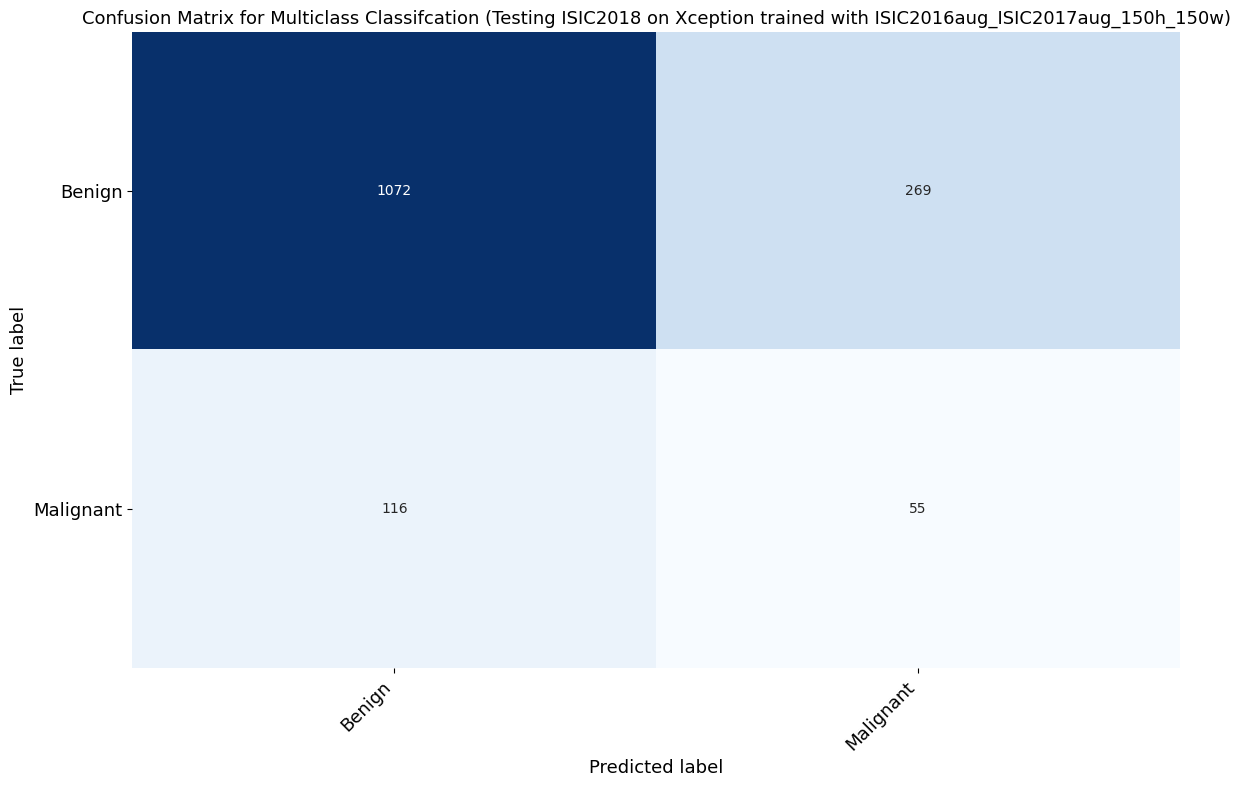

In [14]:
# Training ISIC2016aug+ISIC2017aug with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
picklename = 'ISIC2016aug_ISIC2017aug_150h_150w'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+picklename+'.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ' + picklename
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)              

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
91/91 [==============================] - 3s 35ms/step - loss: 0.5091 - accuracy: 0.7618 - val_loss: 0.5655 - val_accuracy: 0.7338
Epoch 3/20
91/91 [==============================] - 3s 34ms/step - loss: 0.4456 - accuracy: 0.7891 - val_loss: 0.5066 - val_accuracy: 0.7647
Epoch 4/20
91/91 [==============================] - 3s 35ms/step - loss: 0.3958 - accuracy: 0.8173 - val_loss: 0.5049 - val_accuracy: 0.7774
Epoch 5/20
91/91 [==============================] - 3s 35ms/step - loss: 0.3498 - accuracy: 0.8442 - val_loss: 0.5041 - val_accuracy: 0.7857
Epoch 6/20
91/91 [==============================] - 3s 36ms/step - loss: 0.3225 - accuracy: 0.8615 - val_loss: 0.4795 - val_accuracy: 0.8030
Epoch 7/20
91/91 [==============================] - 3s 35ms/step - loss: 0.2760 - accuracy: 0.8793 - val_loss: 0.4775 - val_accuracy: 0.8015
Epoch 8/20
91/91 [==============================] - 3s 37ms/step - loss: 0.2550 - accuracy: 0.8909 - val_loss: 0.5352 - val_accuracy: 0.7902
Epoch 9/20
91

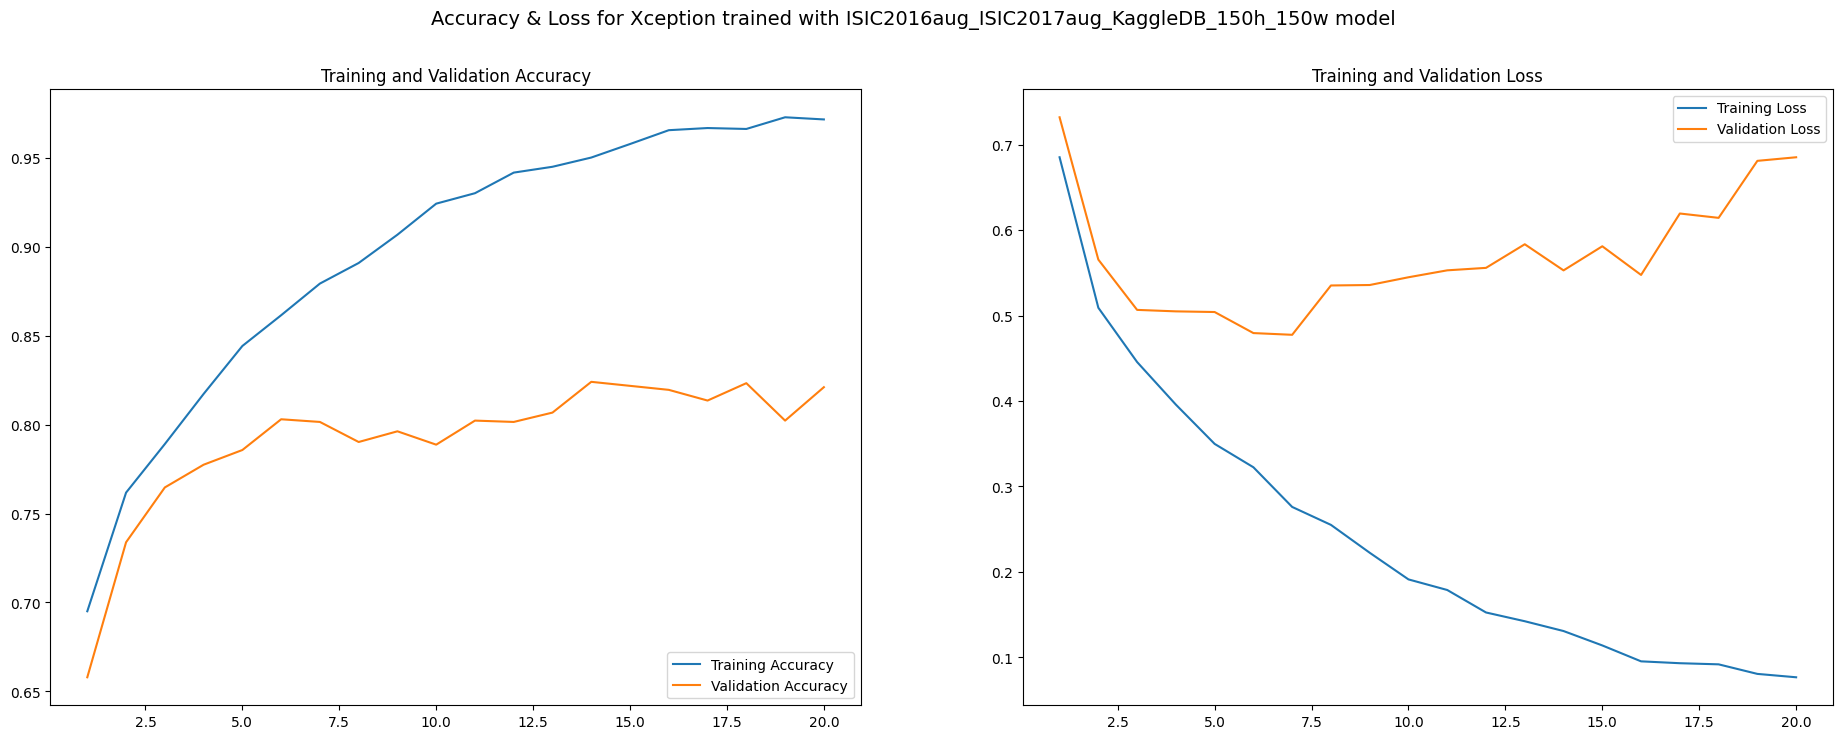

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model...



52/52 [==============================] - 1s 16ms/step - loss: 0.1582 - accuracy: 0.9469
Train loss = 0.15823087096214294  ;  Train accuracy = 94.69%

32/32 [==============================] - 1s 15ms/step - loss: 0.5153 - accuracy: 0.7890
Validation loss = 0.5152696967124939  ;  Validation accuracy = 78.90%

21/21 [==============================] - 0s 15ms/step - loss: 0.4945 - accuracy: 0.7848
Test loss = 0.4944629967212677  ;  Test accuracy = 78.48%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w...
Model report for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.94      0.97      0.95       903
   Malignant       0.96      0.92      0.94       734

    accuracy                           0.95      1637
   macro avg       0.95      0.94      0.95      1637
weighted avg       0.95     

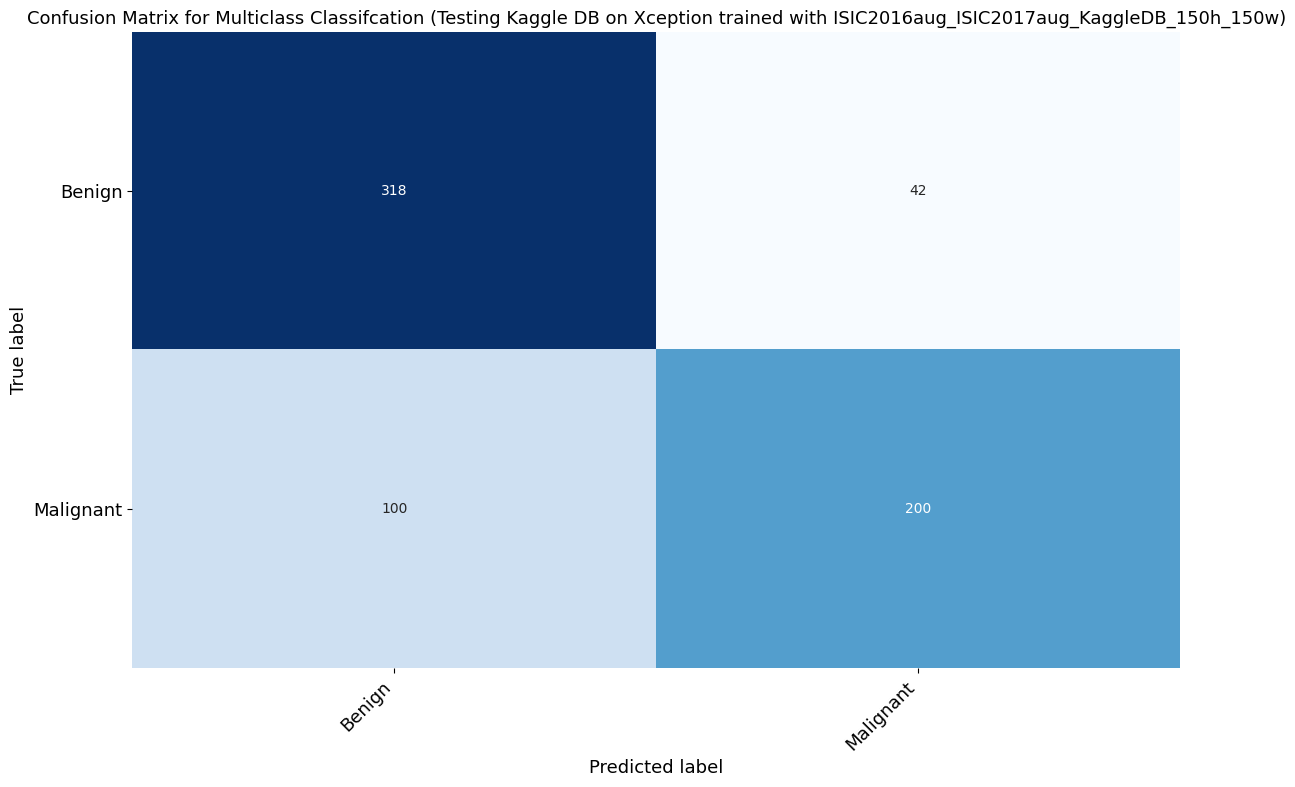

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model...



251/251 [==============================] - 5s 16ms/step - loss: 0.6721 - accuracy: 0.7323
Train loss = 0.6721208691596985  ;  Train accuracy = 73.23%

28/28 [==============================] - 0s 15ms/step - loss: 0.4218 - accuracy: 0.8460
Validation loss = 0.42184191942214966  ;  Validation accuracy = 84.60%

35/35 [==============================] - 1s 15ms/step - loss: 0.4058 - accuracy: 0.8522
Test loss = 0.4057893753051758  ;  Test accuracy = 85.22%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w...
Model report for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.93      0.75      0.83      6994
   Malignant       0.27      0.62      0.37      1035

    accuracy                           0.73      8029
   macro avg       0.60      0.68      0.60      8029
weighted avg       0.84     

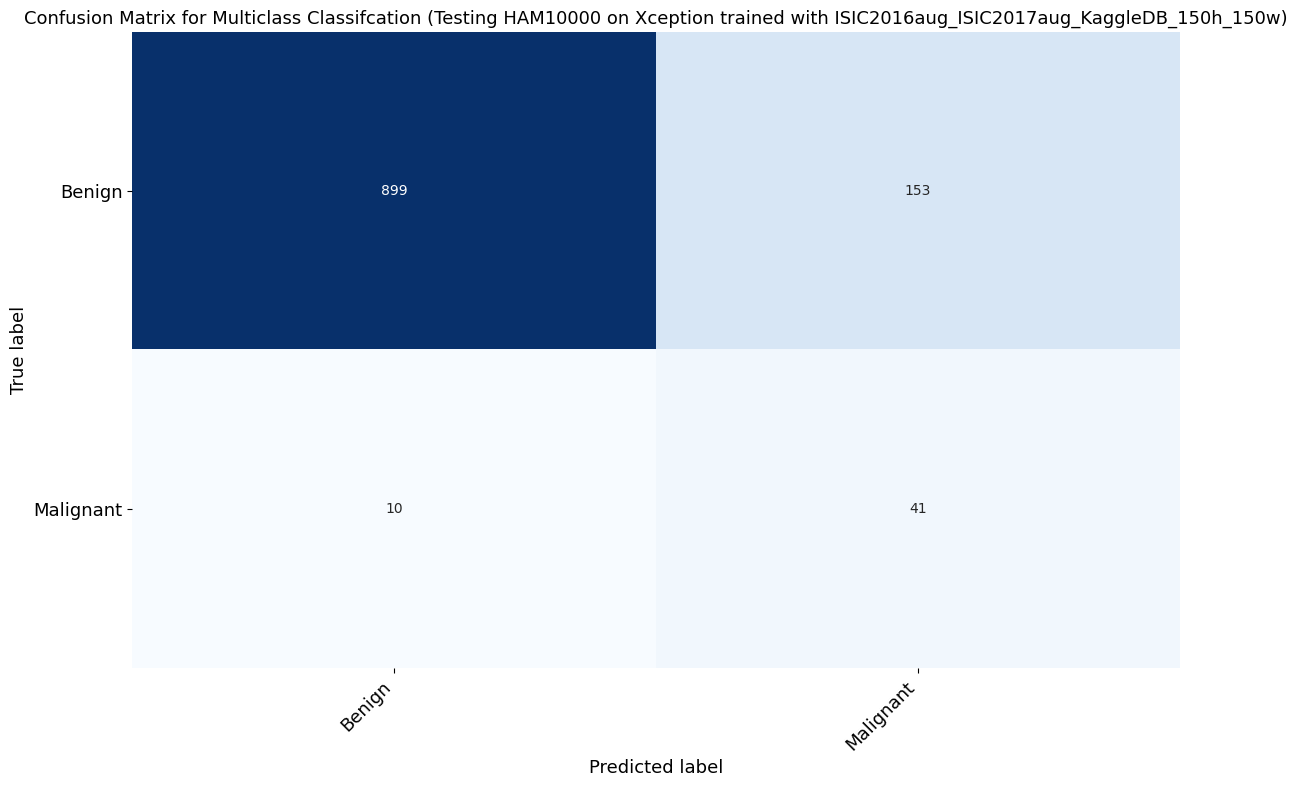

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model...



23/23 [==============================] - 1s 16ms/step - loss: 0.1409 - accuracy: 0.9708
Train loss = 0.14087532460689545  ;  Train accuracy = 97.08%

6/6 [==============================] - 0s 15ms/step - loss: 0.2687 - accuracy: 0.8833
Validation loss = 0.2687106728553772  ;  Validation accuracy = 88.33%

12/12 [==============================] - 0s 16ms/step - loss: 0.3219 - accuracy: 0.8865
Test loss = 0.3218597173690796  ;  Test accuracy = 88.65%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w...
Model report for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.99      0.97      0.98       583
   Malignant       0.90      0.96      0.93       137

    accuracy                           0.97       720
   macro avg       0.94      0.97      0.95       720
weighted avg       0.97      0.9

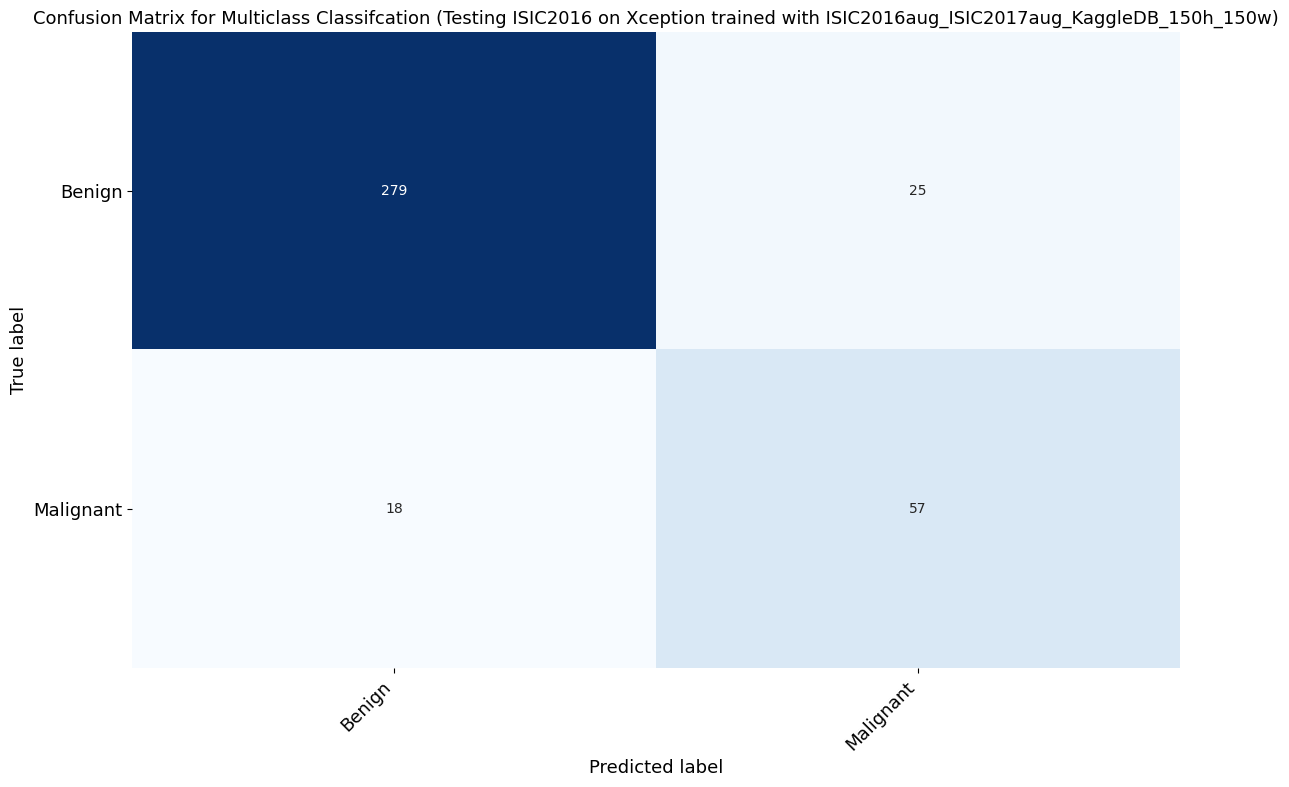

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model...



63/63 [==============================] - 2s 17ms/step - loss: 0.1678 - accuracy: 0.9480
Train loss = 0.16780517995357513  ;  Train accuracy = 94.80%

5/5 [==============================] - 0s 15ms/step - loss: 0.4761 - accuracy: 0.7867
Validation loss = 0.47614210844039917  ;  Validation accuracy = 78.67%

19/19 [==============================] - 0s 16ms/step - loss: 0.5377 - accuracy: 0.7950
Test loss = 0.5376827716827393  ;  Test accuracy = 79.50%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w...
Model report for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.97      0.97      0.97      1626
   Malignant       0.87      0.85      0.86       374

    accuracy                           0.95      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.95      0.

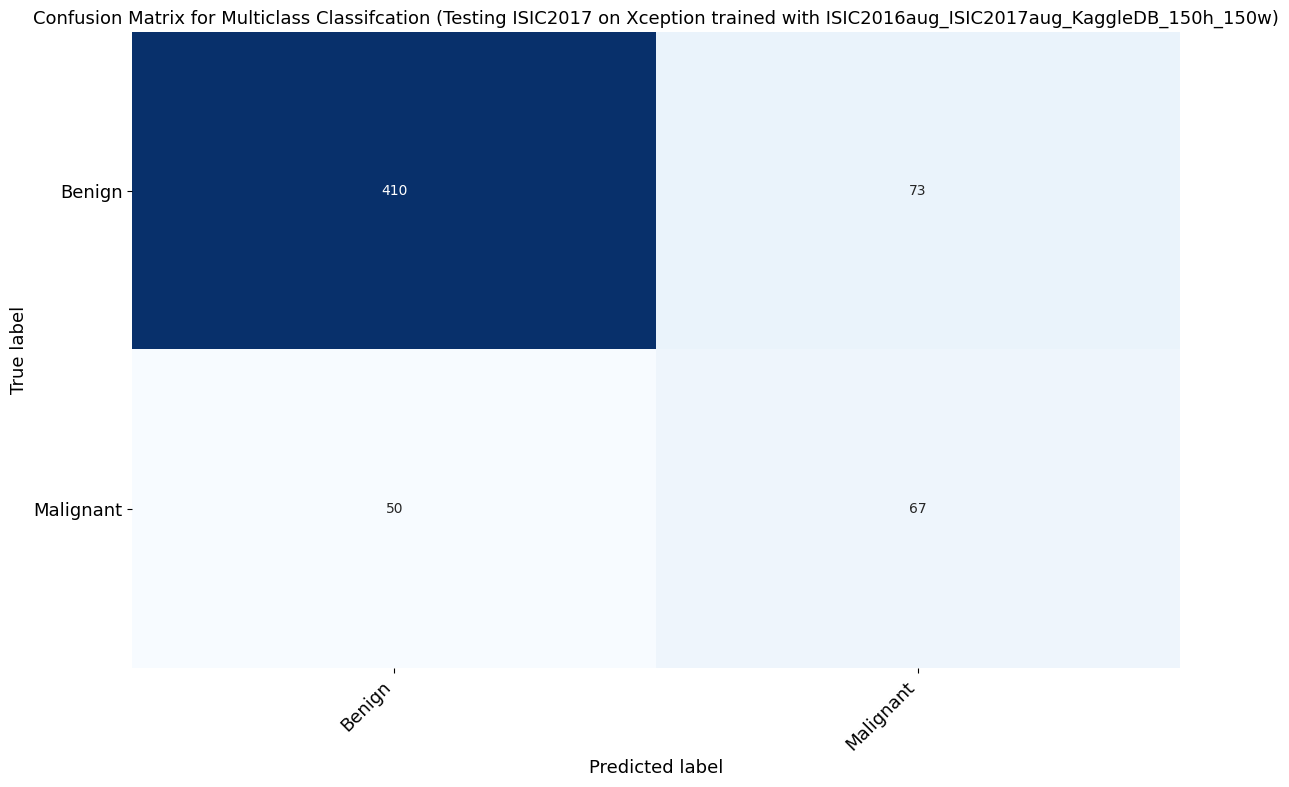

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model...



313/313 [==============================] - 6s 16ms/step - loss: 0.6207 - accuracy: 0.7556
Train loss = 0.6207218766212463  ;  Train accuracy = 75.56%

7/7 [==============================] - 0s 14ms/step - loss: 0.7066 - accuracy: 0.7358
Validation loss = 0.7066172957420349  ;  Validation accuracy = 73.58%

48/48 [==============================] - 1s 16ms/step - loss: 0.7298 - accuracy: 0.7183
Test loss = 0.7298266887664795  ;  Test accuracy = 71.83%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w...
Model report for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.94      0.77      0.85      8902
   Malignant       0.26      0.63      0.36      1113

    accuracy                           0.76     10015
   macro avg       0.60      0.70      0.61     10015
weighted avg       0.87      0.

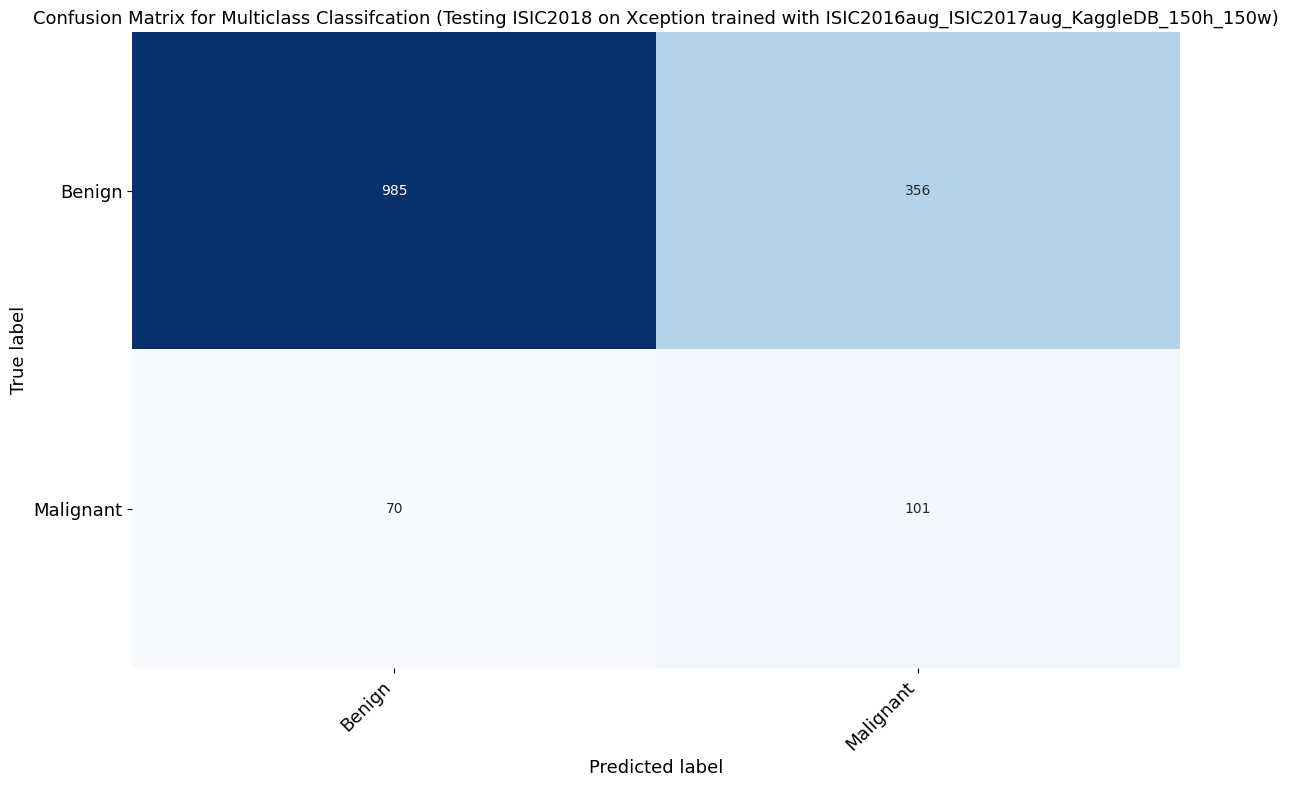

In [15]:
# Training ISIC2016aug+ISIC2017aug+KaggleDB with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
picklename = 'ISIC2016aug_ISIC2017aug_KaggleDB_150h_150w'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+picklename+'.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ' + picklename
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 512)               2048      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
320/320 [==============================] - 10s 30ms/step - loss: 0.4623 - accuracy: 0.7831 - val_loss: 0.5148 - val_accuracy: 0.7551
Epoch 3/20
320/320 [==============================] - 10s 31ms/step - loss: 0.4223 - accuracy: 0.8020 - val_loss: 0.4766 - val_accuracy: 0.7741
Epoch 4/20
320/320 [==============================] - 10s 31ms/step - loss: 0.3951 - accuracy: 0.8178 - val_loss: 0.4716 - val_accuracy: 0.7866
Epoch 5/20
320/320 [==============================] - 10s 31ms/step - loss: 0.3646 - accuracy: 0.8375 - val_loss: 0.4433 - val_accuracy: 0.8024
Epoch 6/20
320/320 [==============================] - 10s 30ms/step - loss: 0.3423 - accuracy: 0.8467 - val_loss: 0.4599 - val_accuracy: 0.7945
Epoch 7/20
320/320 [==============================] - 10s 30ms/step - loss: 0.3228 - accuracy: 0.8585 - val_loss: 0.4391 - val_accuracy: 0.8050
Epoch 8/20
320/320 [==============================] - 10s 30ms/step - loss: 0.3009 - accuracy: 0.8697 - val_loss: 0.4622 - val_accuracy:

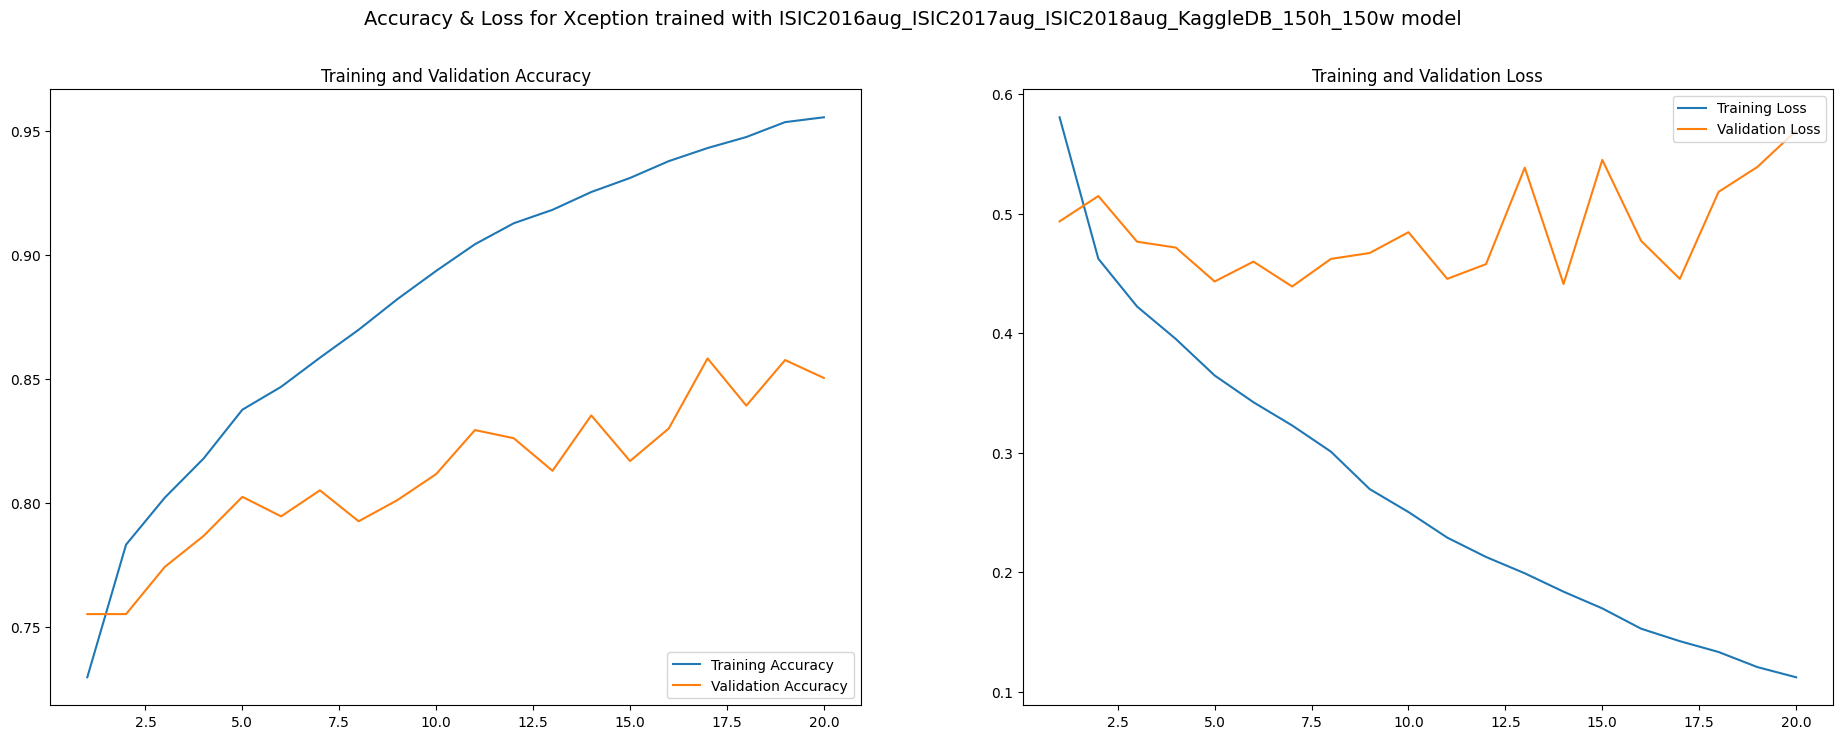

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model...



52/52 [==============================] - 1s 16ms/step - loss: 0.2472 - accuracy: 0.8900
Train loss = 0.24719186127185822  ;  Train accuracy = 89.00%

32/32 [==============================] - 1s 16ms/step - loss: 0.4654 - accuracy: 0.7930
Validation loss = 0.4654489755630493  ;  Validation accuracy = 79.30%

21/21 [==============================] - 0s 16ms/step - loss: 0.4574 - accuracy: 0.8000
Test loss = 0.4573916494846344  ;  Test accuracy = 80.00%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w...
Model report for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.84      0.99      0.91       903
   Malignant       0.98      0.77      0.86       734

    accuracy                           0.89      1637
   macro avg       0.91      0.88      0.89      1637
weig

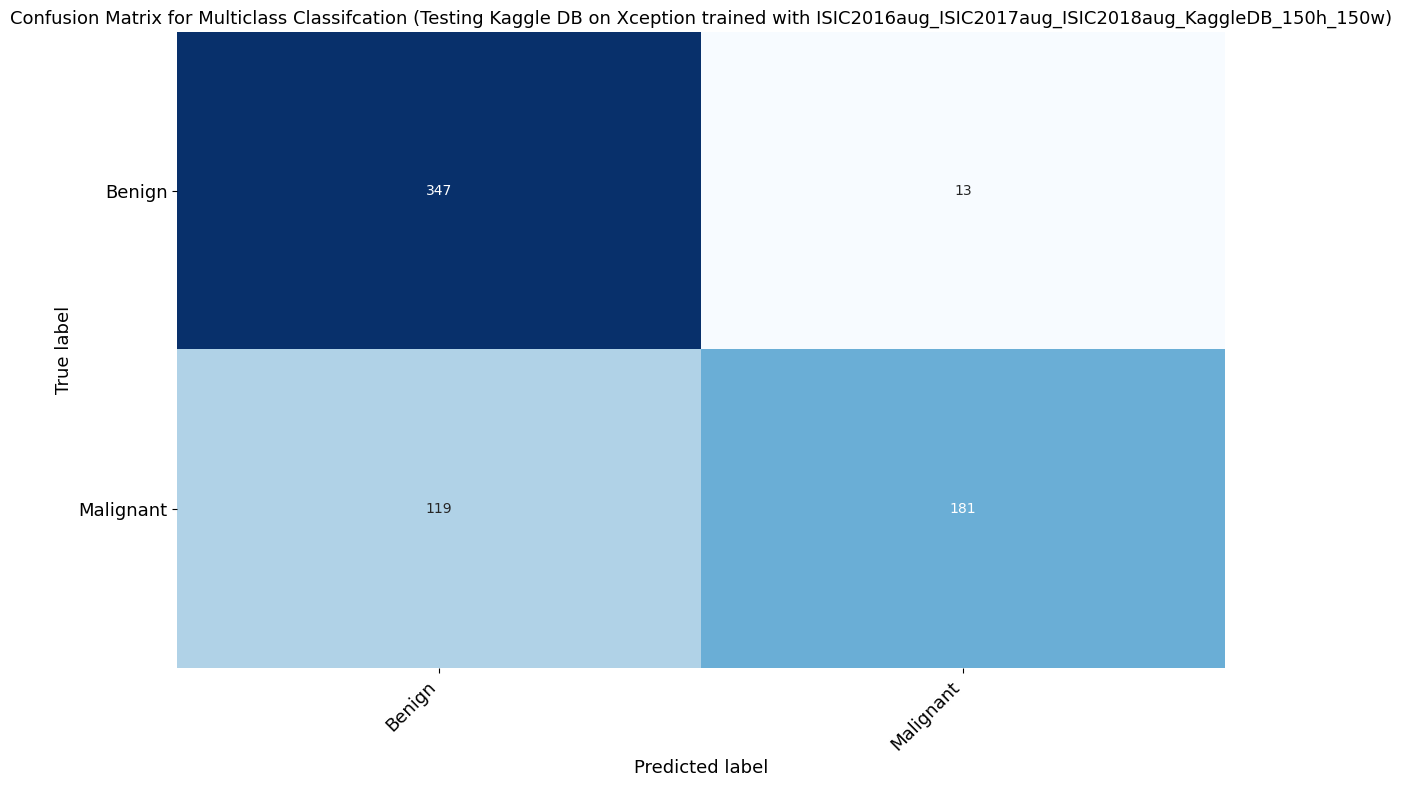

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model...



251/251 [==============================] - 5s 17ms/step - loss: 0.2128 - accuracy: 0.9222
Train loss = 0.21275784075260162  ;  Train accuracy = 92.22%

28/28 [==============================] - 0s 16ms/step - loss: 0.1074 - accuracy: 0.9672
Validation loss = 0.10740307718515396  ;  Validation accuracy = 96.72%

35/35 [==============================] - 1s 16ms/step - loss: 0.1187 - accuracy: 0.9574
Test loss = 0.11866303533315659  ;  Test accuracy = 95.74%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w...
Model report for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.95      0.96      0.96      6994
   Malignant       0.71      0.67      0.69      1035

    accuracy                           0.92      8029
   macro avg       0.83      0.81      0.82      8029
we

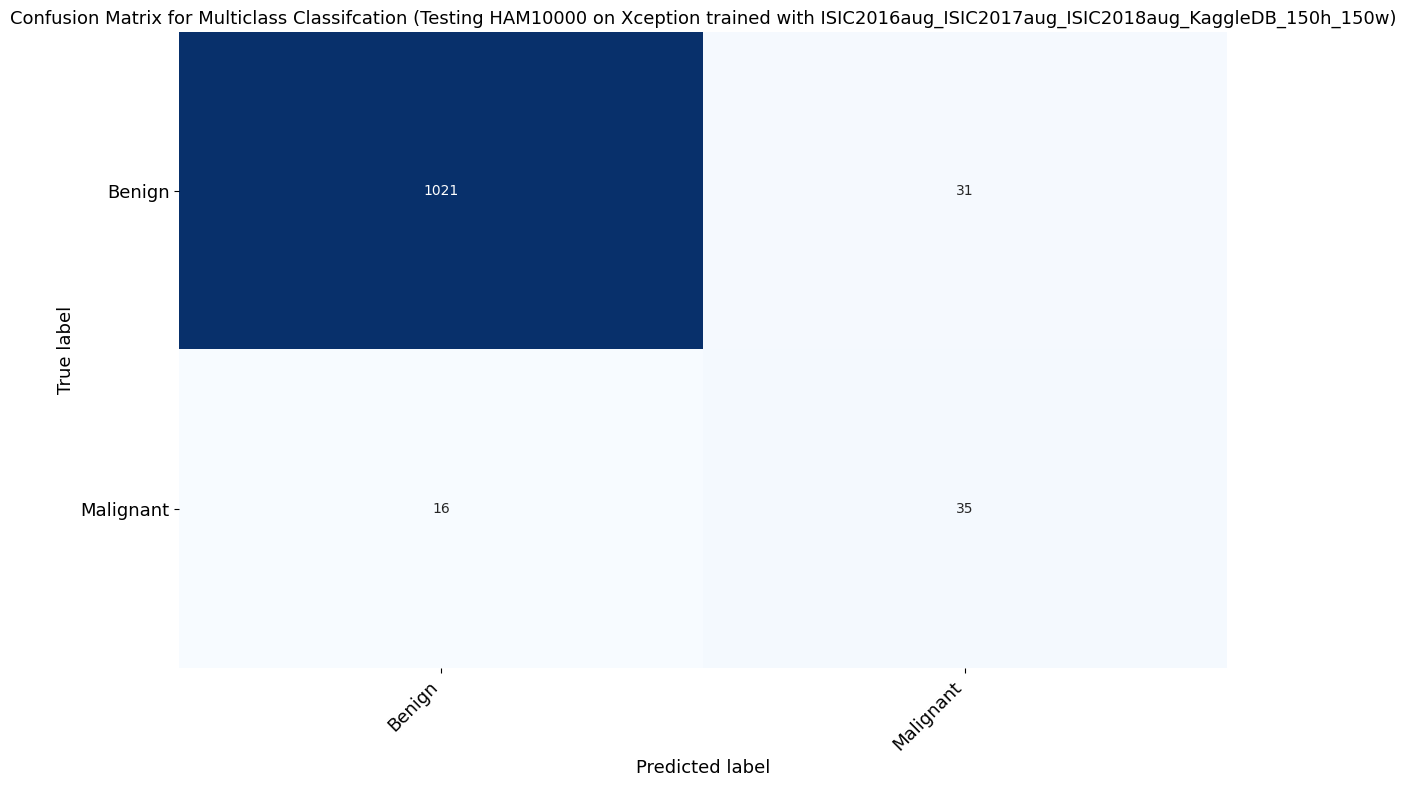

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model...



23/23 [==============================] - 1s 16ms/step - loss: 0.2250 - accuracy: 0.9236
Train loss = 0.22497443854808807  ;  Train accuracy = 92.36%

6/6 [==============================] - 0s 15ms/step - loss: 0.3149 - accuracy: 0.8778
Validation loss = 0.31488871574401855  ;  Validation accuracy = 87.78%

12/12 [==============================] - 0s 15ms/step - loss: 0.3862 - accuracy: 0.8391
Test loss = 0.3861563205718994  ;  Test accuracy = 83.91%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w...
Model report for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.95      0.95      0.95       583
   Malignant       0.80      0.80      0.80       137

    accuracy                           0.92       720
   macro avg       0.88      0.87      0.88       720
weighte

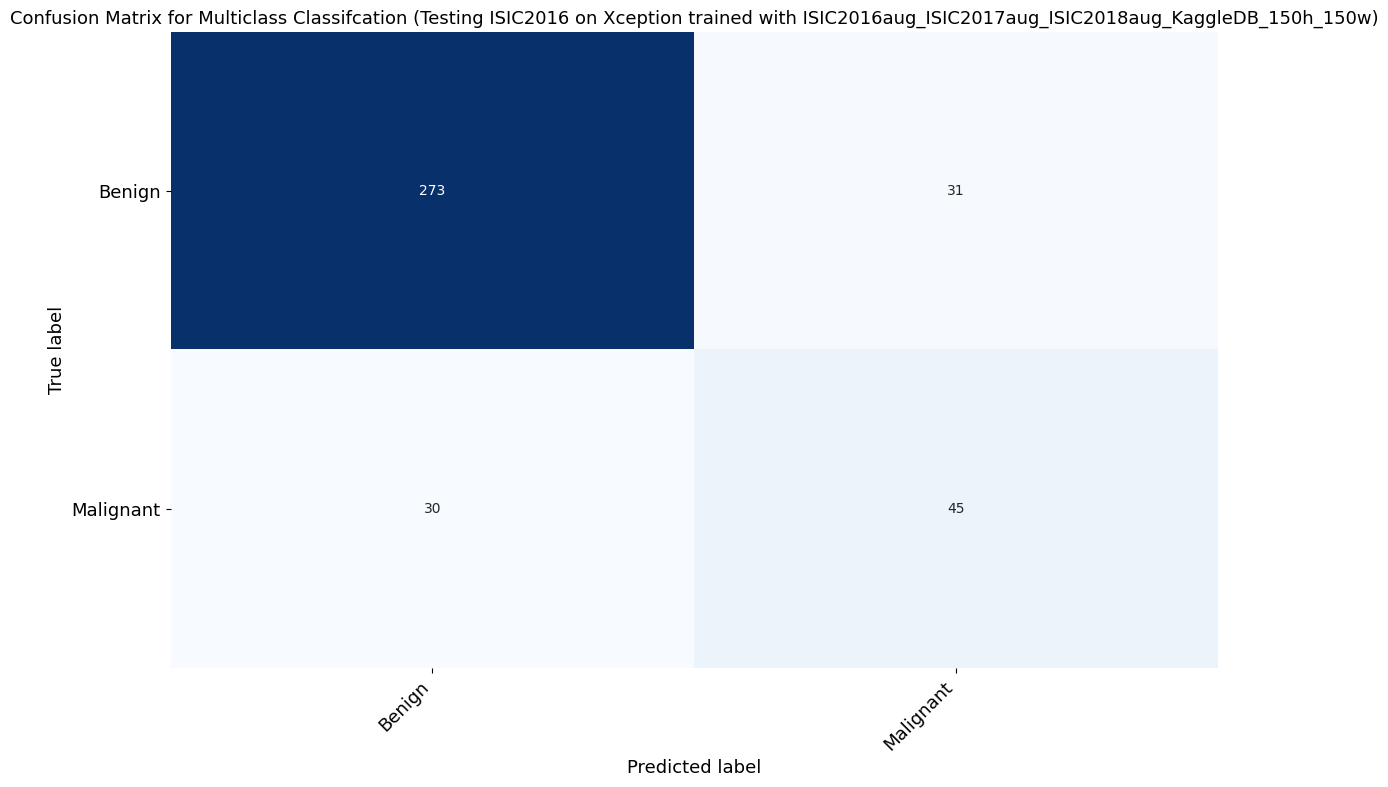

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model...



63/63 [==============================] - 2s 16ms/step - loss: 0.2455 - accuracy: 0.9085
Train loss = 0.24553386867046356  ;  Train accuracy = 90.85%

5/5 [==============================] - 0s 15ms/step - loss: 0.5156 - accuracy: 0.7733
Validation loss = 0.5156223177909851  ;  Validation accuracy = 77.33%

19/19 [==============================] - 0s 16ms/step - loss: 0.4899 - accuracy: 0.8017
Test loss = 0.4899066686630249  ;  Test accuracy = 80.17%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w...
Model report for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.93      0.95      0.94      1626
   Malignant       0.78      0.71      0.74       374

    accuracy                           0.91      2000
   macro avg       0.86      0.83      0.84      2000
weighted

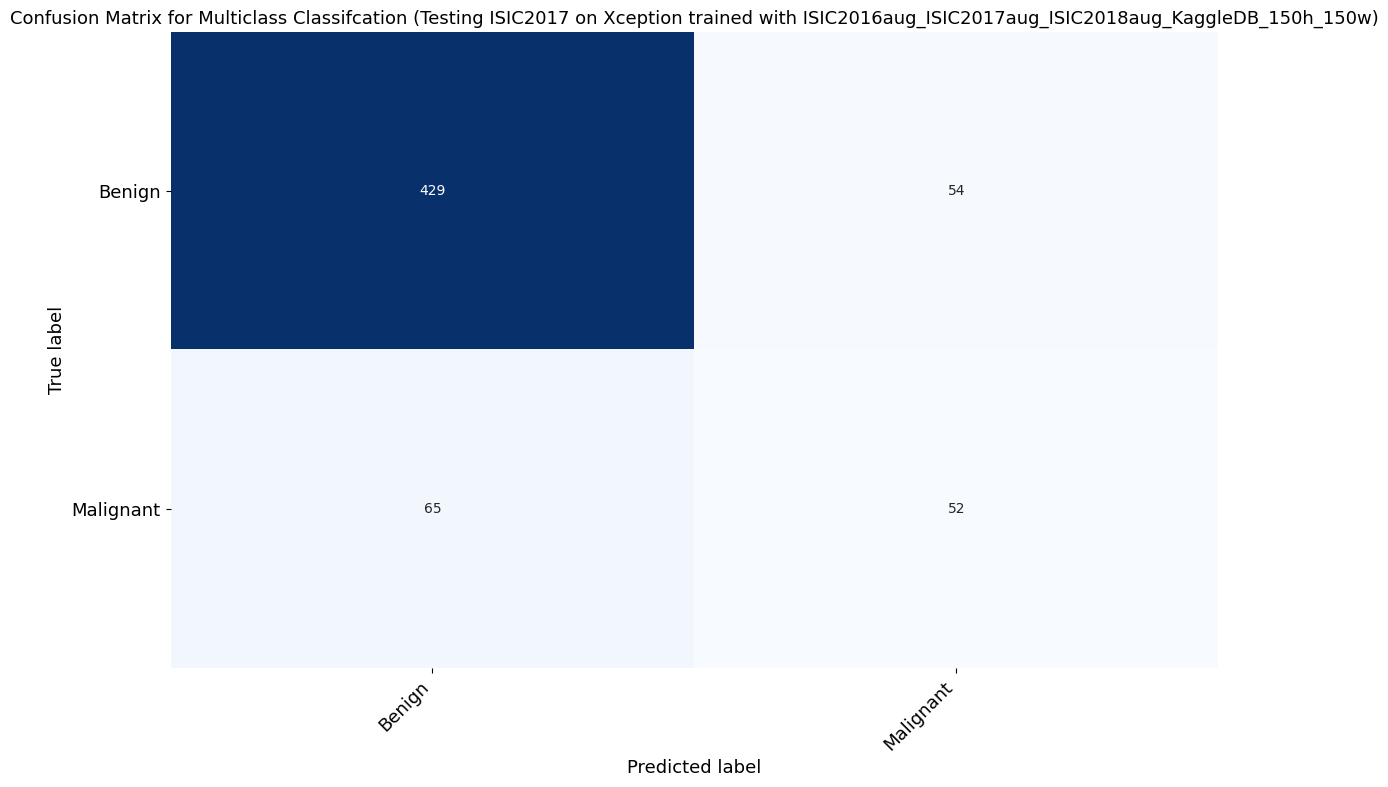

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model...



313/313 [==============================] - 5s 16ms/step - loss: 0.1931 - accuracy: 0.9300
Train loss = 0.19310571253299713  ;  Train accuracy = 93.00%

7/7 [==============================] - 0s 14ms/step - loss: 0.3588 - accuracy: 0.8238
Validation loss = 0.35883232951164246  ;  Validation accuracy = 82.38%

48/48 [==============================] - 1s 15ms/step - loss: 0.3777 - accuracy: 0.8366
Test loss = 0.377691388130188  ;  Test accuracy = 83.66%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w...
Model report for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.96      0.96      0.96      8902
   Malignant       0.69      0.67      0.68      1113

    accuracy                           0.93     10015
   macro avg       0.83      0.82      0.82     10015
weight

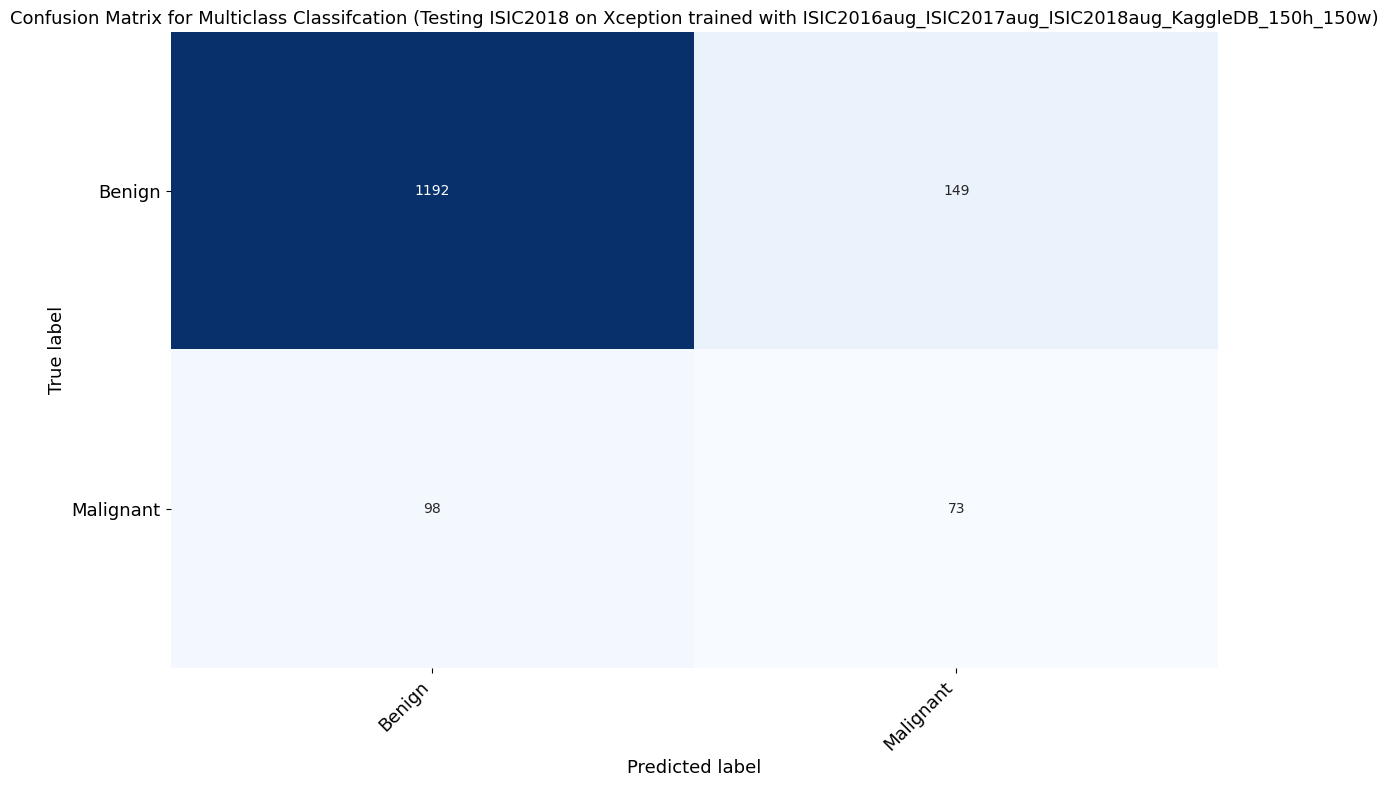

In [16]:
# Training ISIC2016aug+ISIC2017aug+ISIC2018aug+KaggleDB with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
picklename = 'ISIC2016aug_ISIC2017aug_ISIC2018aug_KaggleDB_150h_150w'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+picklename+'.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ' + picklename
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 512)               2048      
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)              

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
838/838 [==============================] - 28s 34ms/step - loss: 0.4654 - accuracy: 0.7776 - val_loss: 0.3848 - val_accuracy: 0.8287
Epoch 3/20
838/838 [==============================] - 27s 32ms/step - loss: 0.4371 - accuracy: 0.7932 - val_loss: 0.3784 - val_accuracy: 0.8331
Epoch 4/20
838/838 [==============================] - 28s 33ms/step - loss: 0.4108 - accuracy: 0.8091 - val_loss: 0.3601 - val_accuracy: 0.8451
Epoch 5/20
838/838 [==============================] - 28s 33ms/step - loss: 0.3896 - accuracy: 0.8211 - val_loss: 0.3555 - val_accuracy: 0.8499
Epoch 6/20
838/838 [==============================] - 28s 33ms/step - loss: 0.3690 - accuracy: 0.8306 - val_loss: 0.3571 - val_accuracy: 0.8481
Epoch 7/20
838/838 [==============================] - 28s 33ms/step - loss: 0.3475 - accuracy: 0.8423 - val_loss: 0.3383 - val_accuracy: 0.8593
Epoch 8/20
838/838 [==============================] - 27s 33ms/step - loss: 0.3278 - accuracy: 0.8518 - val_loss: 0.3391 - val_accuracy:

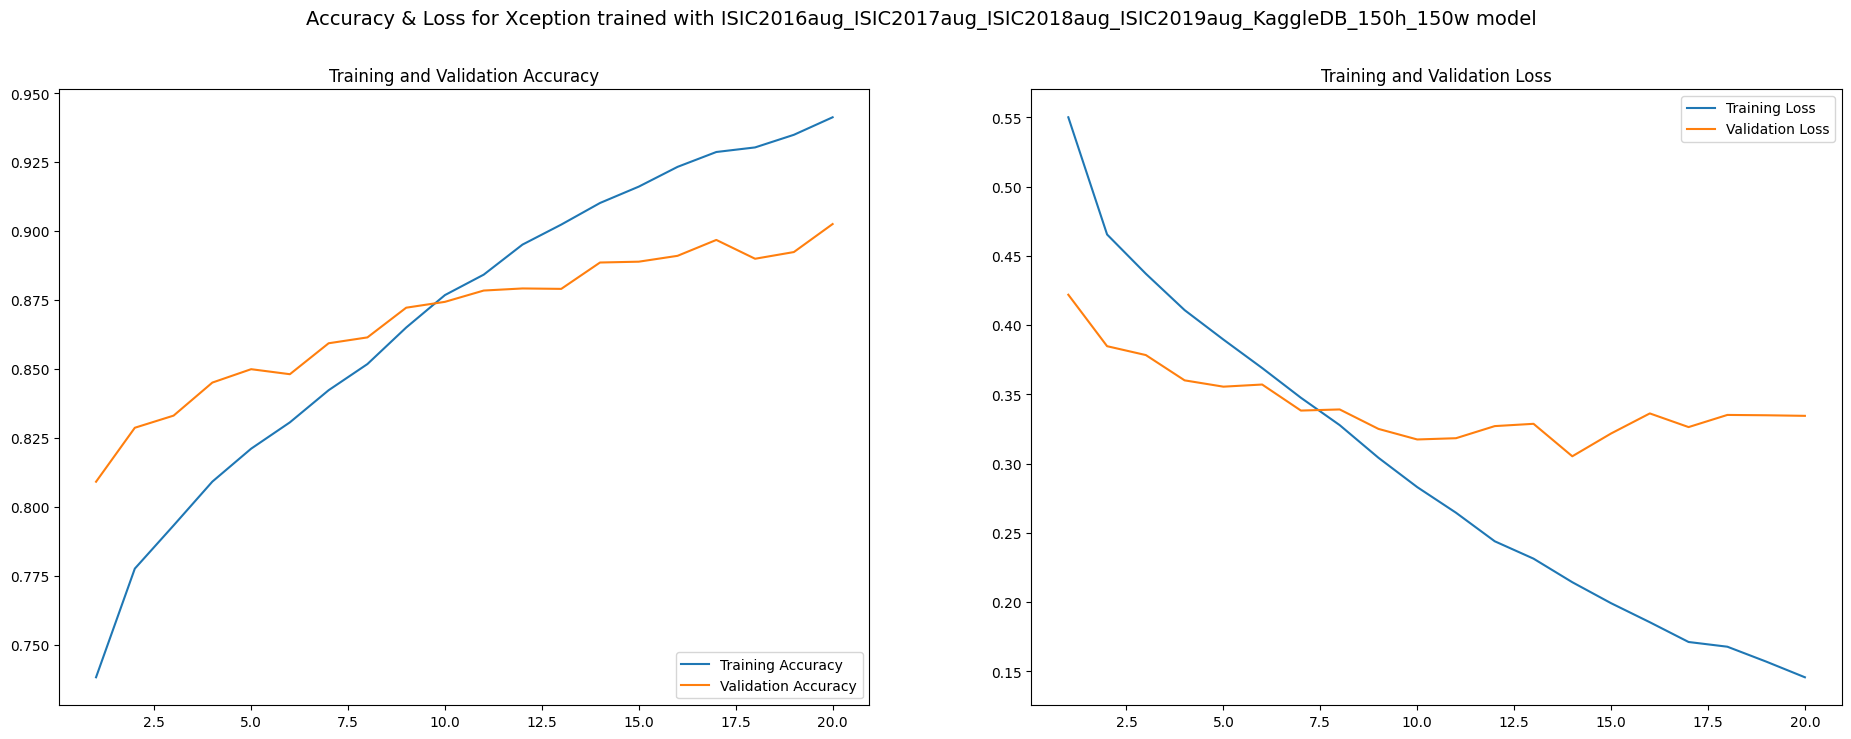

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model...



52/52 [==============================] - 2s 21ms/step - loss: 0.1128 - accuracy: 0.9609
Train loss = 0.11280116438865662  ;  Train accuracy = 96.09%

32/32 [==============================] - 1s 16ms/step - loss: 0.4436 - accuracy: 0.8380
Validation loss = 0.4436330199241638  ;  Validation accuracy = 83.80%

21/21 [==============================] - 0s 16ms/step - loss: 0.3891 - accuracy: 0.8576
Test loss = 0.3891047537326813  ;  Test accuracy = 85.76%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w...
Model report for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.94      1.00      0.97       903
   Malignant       1.00      0.92      0.95       734

    accuracy                           0.96      1637
   macro avg       0.97      0.96 

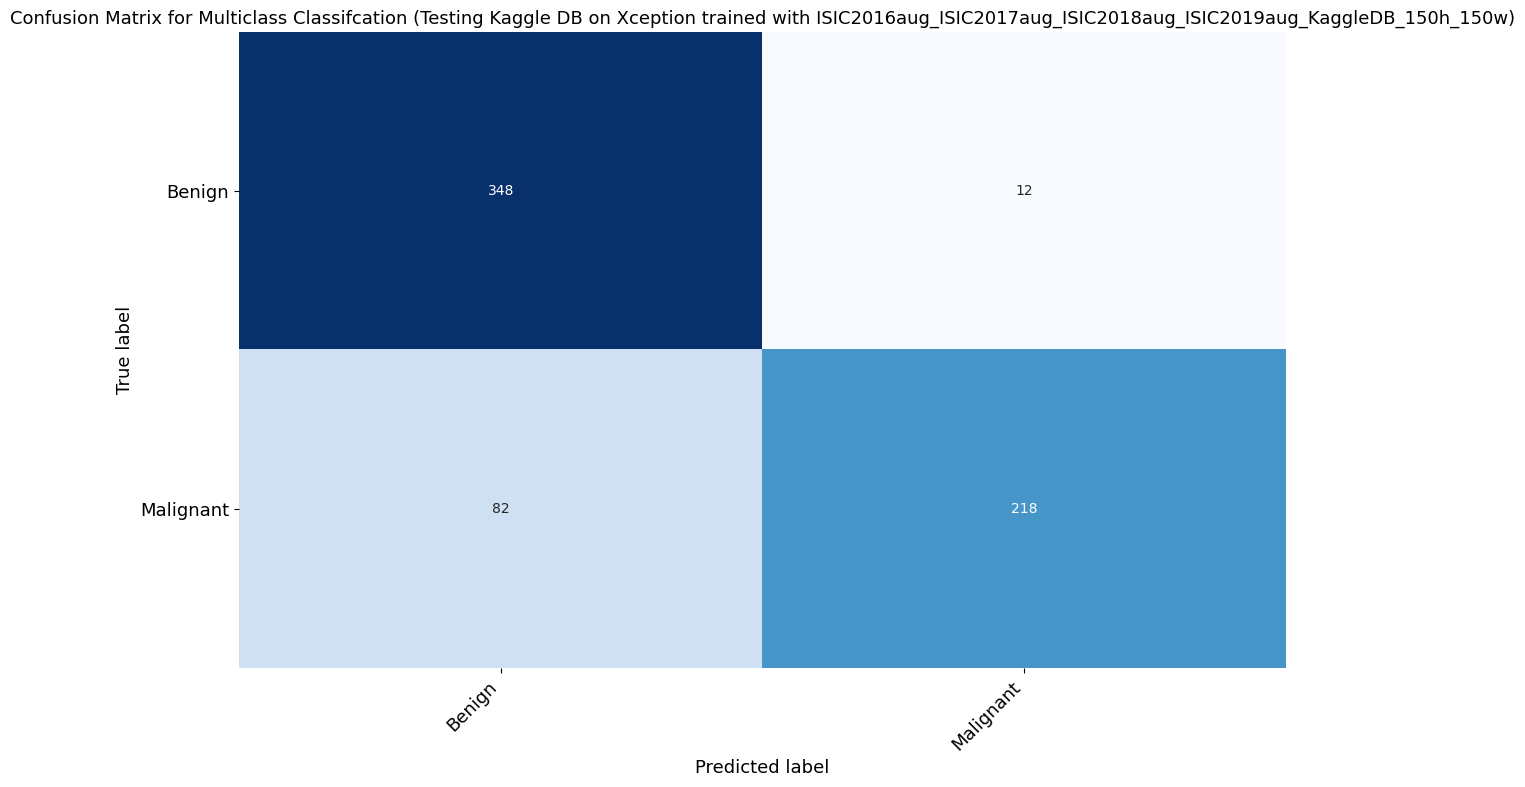

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model...



251/251 [==============================] - 5s 17ms/step - loss: 0.0709 - accuracy: 0.9832
Train loss = 0.07094116508960724  ;  Train accuracy = 98.32%

28/28 [==============================] - 0s 15ms/step - loss: 0.0391 - accuracy: 0.9898
Validation loss = 0.03906691074371338  ;  Validation accuracy = 98.98%

35/35 [==============================] - 1s 16ms/step - loss: 0.0411 - accuracy: 0.9918
Test loss = 0.041113272309303284  ;  Test accuracy = 99.18%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w...
Model report for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      6994
   Malignant       0.93      0.94      0.93      1035

    accuracy                           0.98      8029
   macro avg       0.96      0.

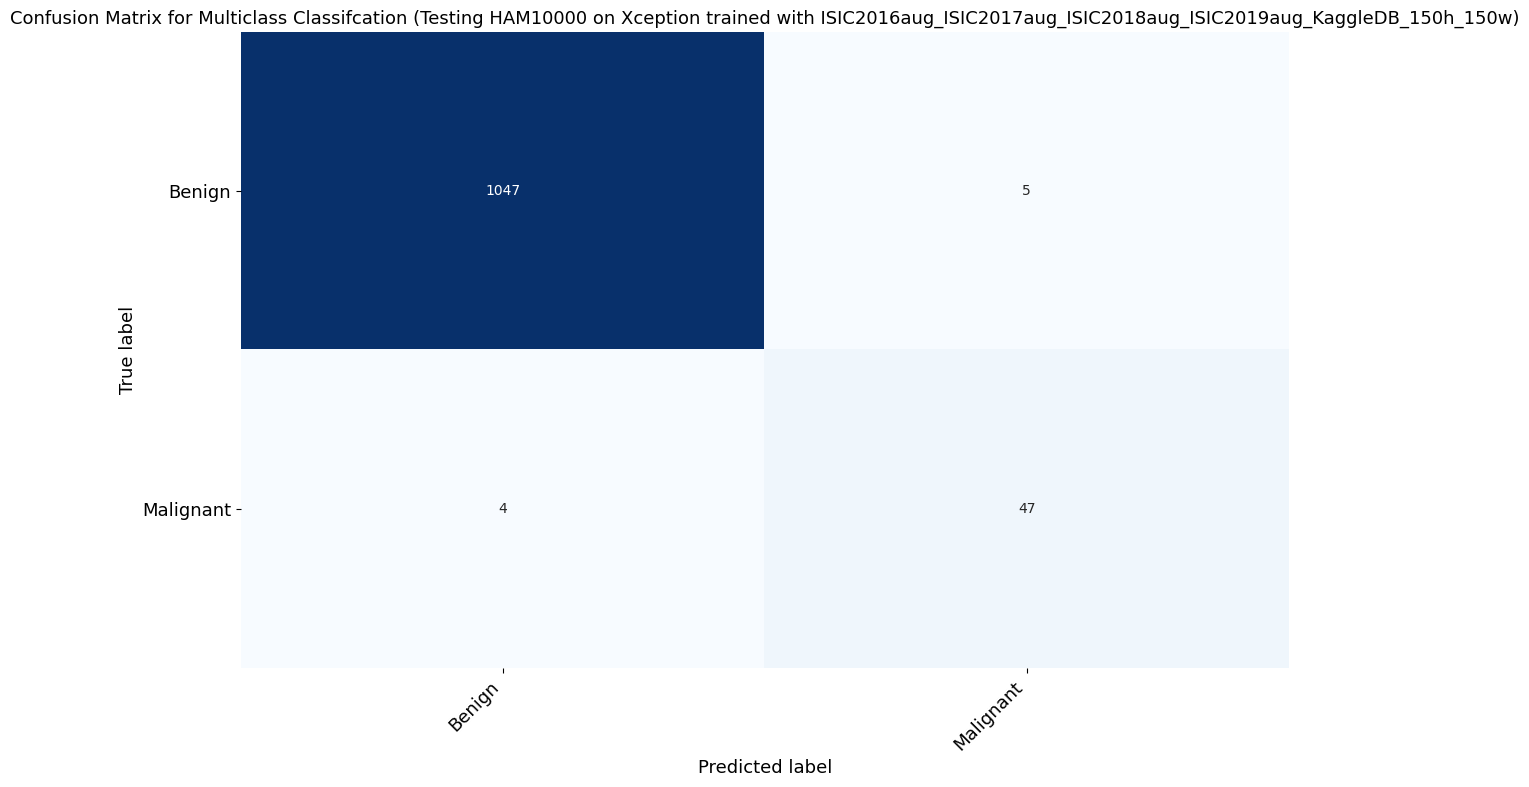

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model...



23/23 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9847
Train loss = 0.075225330889225  ;  Train accuracy = 98.47%

6/6 [==============================] - 0s 19ms/step - loss: 0.1321 - accuracy: 0.9556
Validation loss = 0.13208912312984467  ;  Validation accuracy = 95.56%

12/12 [==============================] - 0s 16ms/step - loss: 0.1851 - accuracy: 0.9288
Test loss = 0.1850651204586029  ;  Test accuracy = 92.88%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w...
Model report for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99       583
   Malignant       0.94      0.98      0.96       137

    accuracy                           0.98       720
   macro avg       0.97      0.98      

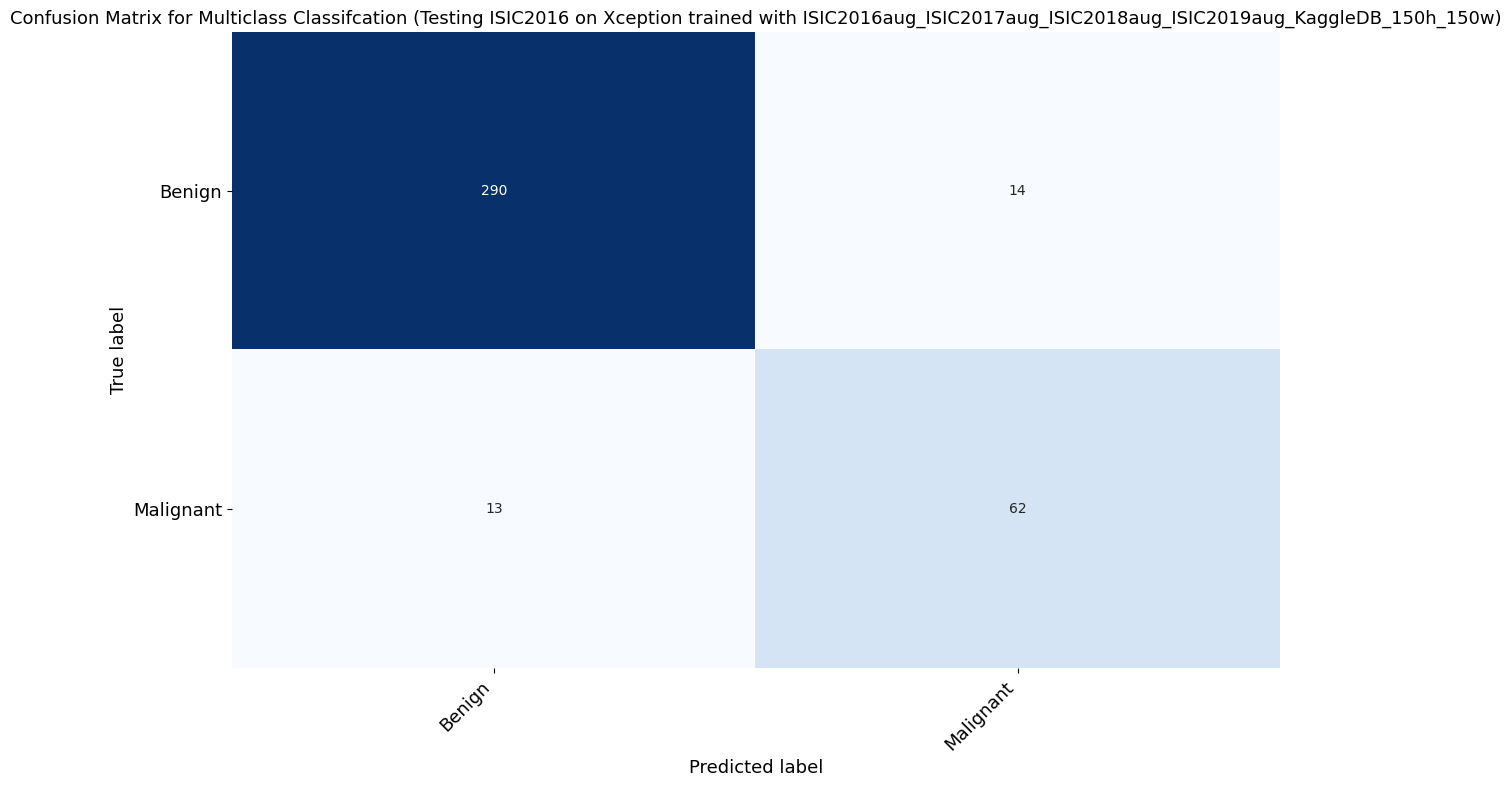

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model...



63/63 [==============================] - 2s 16ms/step - loss: 0.0870 - accuracy: 0.9765
Train loss = 0.08703842759132385  ;  Train accuracy = 97.65%

5/5 [==============================] - 0s 15ms/step - loss: 0.2762 - accuracy: 0.9000
Validation loss = 0.2761690318584442  ;  Validation accuracy = 90.00%

19/19 [==============================] - 0s 16ms/step - loss: 0.2844 - accuracy: 0.8917
Test loss = 0.2844139635562897  ;  Test accuracy = 89.17%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w...
Model report for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.99      0.98      0.99      1626
   Malignant       0.93      0.95      0.94       374

    accuracy                           0.98      2000
   macro avg       0.96      0.97     

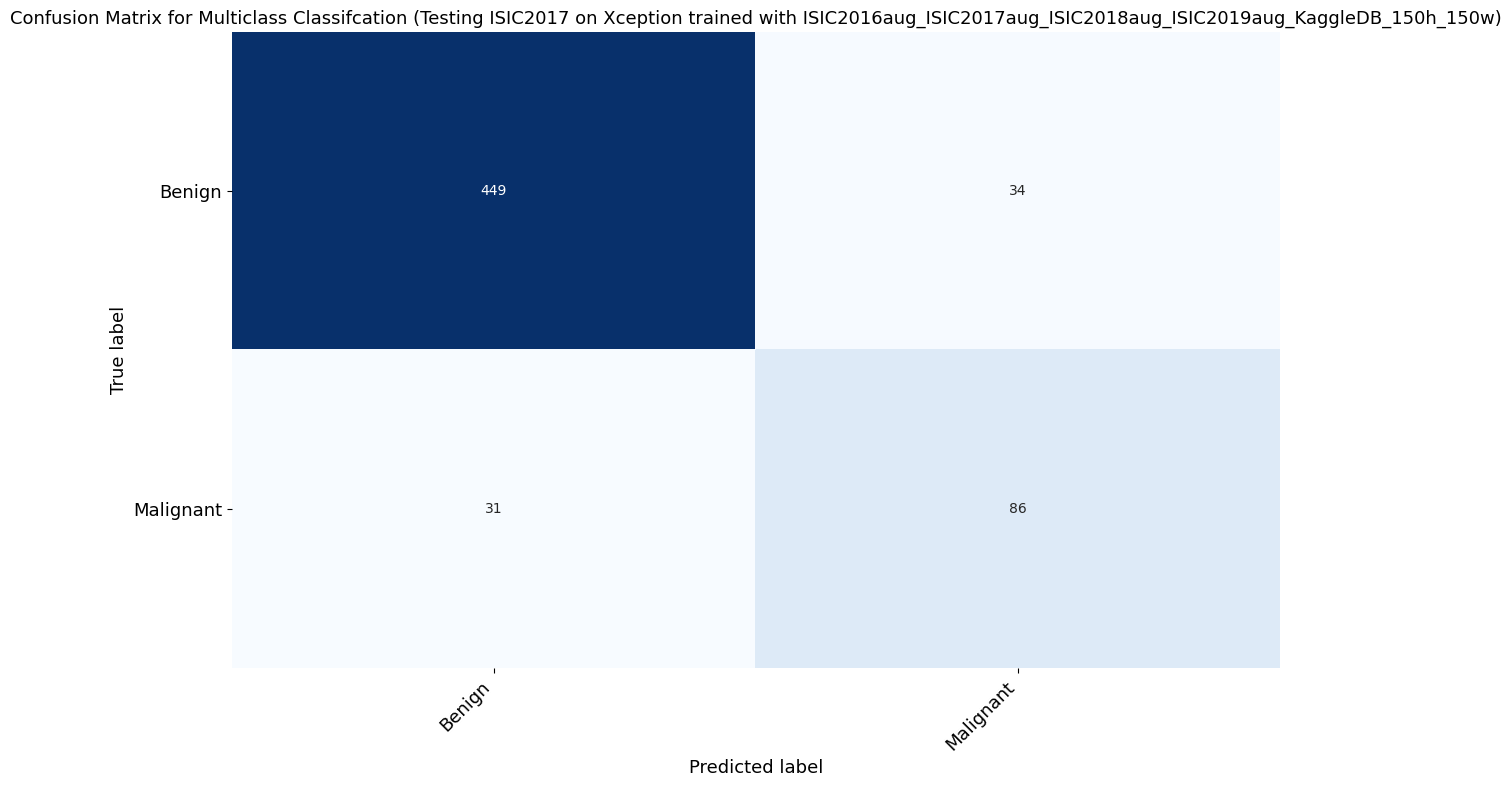

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model...



313/313 [==============================] - 6s 16ms/step - loss: 0.0648 - accuracy: 0.9847
Train loss = 0.06484576314687729  ;  Train accuracy = 98.47%

7/7 [==============================] - 0s 14ms/step - loss: 0.3560 - accuracy: 0.8860
Validation loss = 0.35602909326553345  ;  Validation accuracy = 88.60%

48/48 [==============================] - 1s 21ms/step - loss: 0.4643 - accuracy: 0.8313
Test loss = 0.46430376172065735  ;  Test accuracy = 83.13%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w...
Model report for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      8902
   Malignant       0.93      0.94      0.93      1113

    accuracy                           0.98     10015
   macro avg       0.96      0.96 

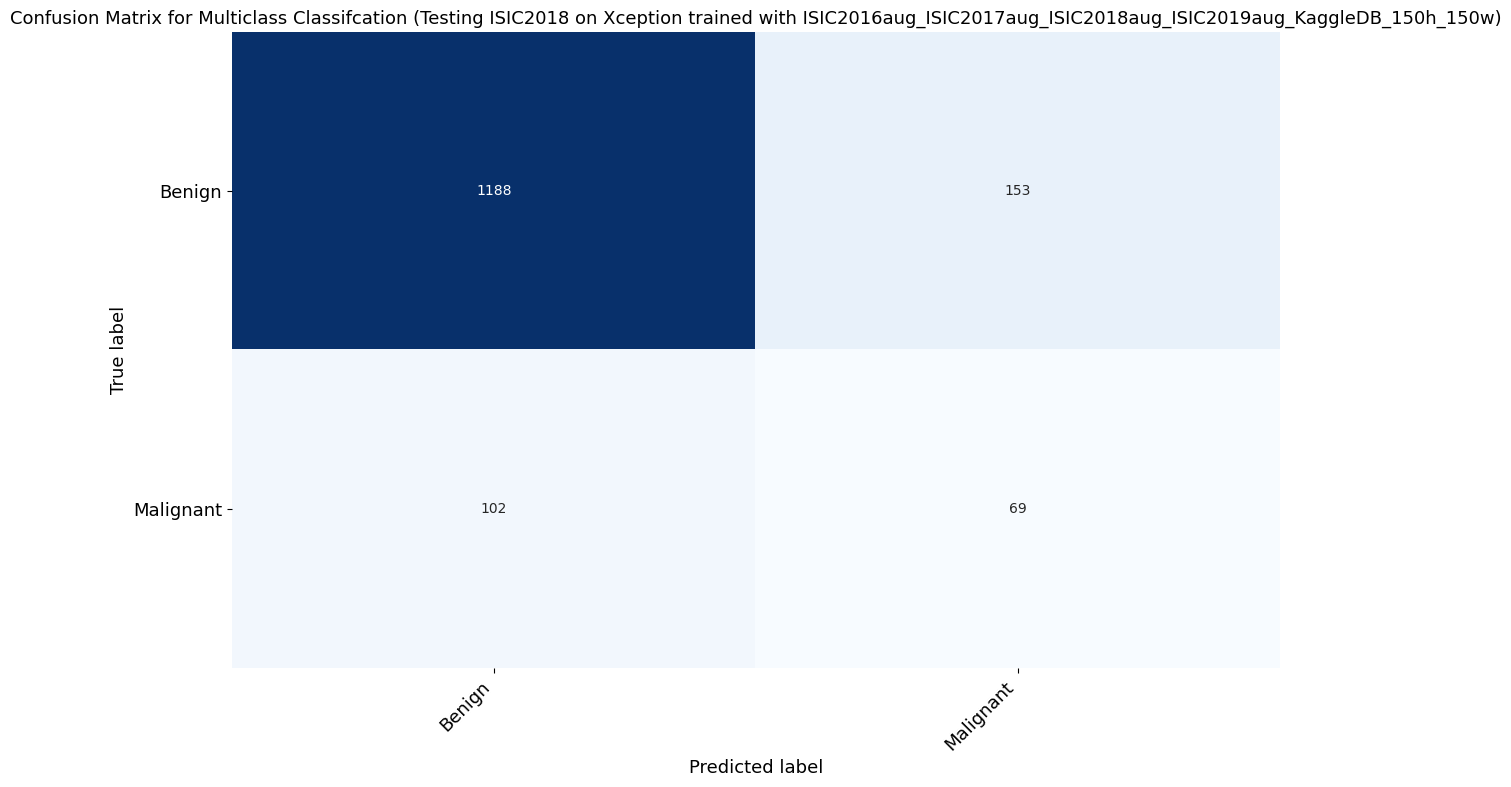

In [17]:
# Training ISIC2016aug+ISIC2017aug+ISIC2018aug+ISIC2019aug+KaggleDB with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
picklename = 'ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_KaggleDB_150h_150w'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+picklename+'.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ' + picklename
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)



Reloading 'melanoma.cnn'.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 512)               2048      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)       

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.3917 - accuracy: 0.8137 - val_loss: 0.2489 - val_accuracy: 0.9030
Epoch 3/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.3700 - accuracy: 0.8249 - val_loss: 0.2413 - val_accuracy: 0.9046
Epoch 4/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.3519 - accuracy: 0.8345 - val_loss: 0.2332 - val_accuracy: 0.9059
Epoch 5/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.3360 - accuracy: 0.8444 - val_loss: 0.2253 - val_accuracy: 0.9097
Epoch 6/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.3227 - accuracy: 0.8519 - val_loss: 0.2202 - val_accuracy: 0.9130
Epoch 7/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.3062 - accuracy: 0.8614 - val_loss: 0.2200 - val_accuracy: 0.9143
Epoch 8/20
1464/1464 [==============================] - 54s 37ms/step - loss: 0.2889 - accuracy: 0.8705 - val_loss: 0.2149 -

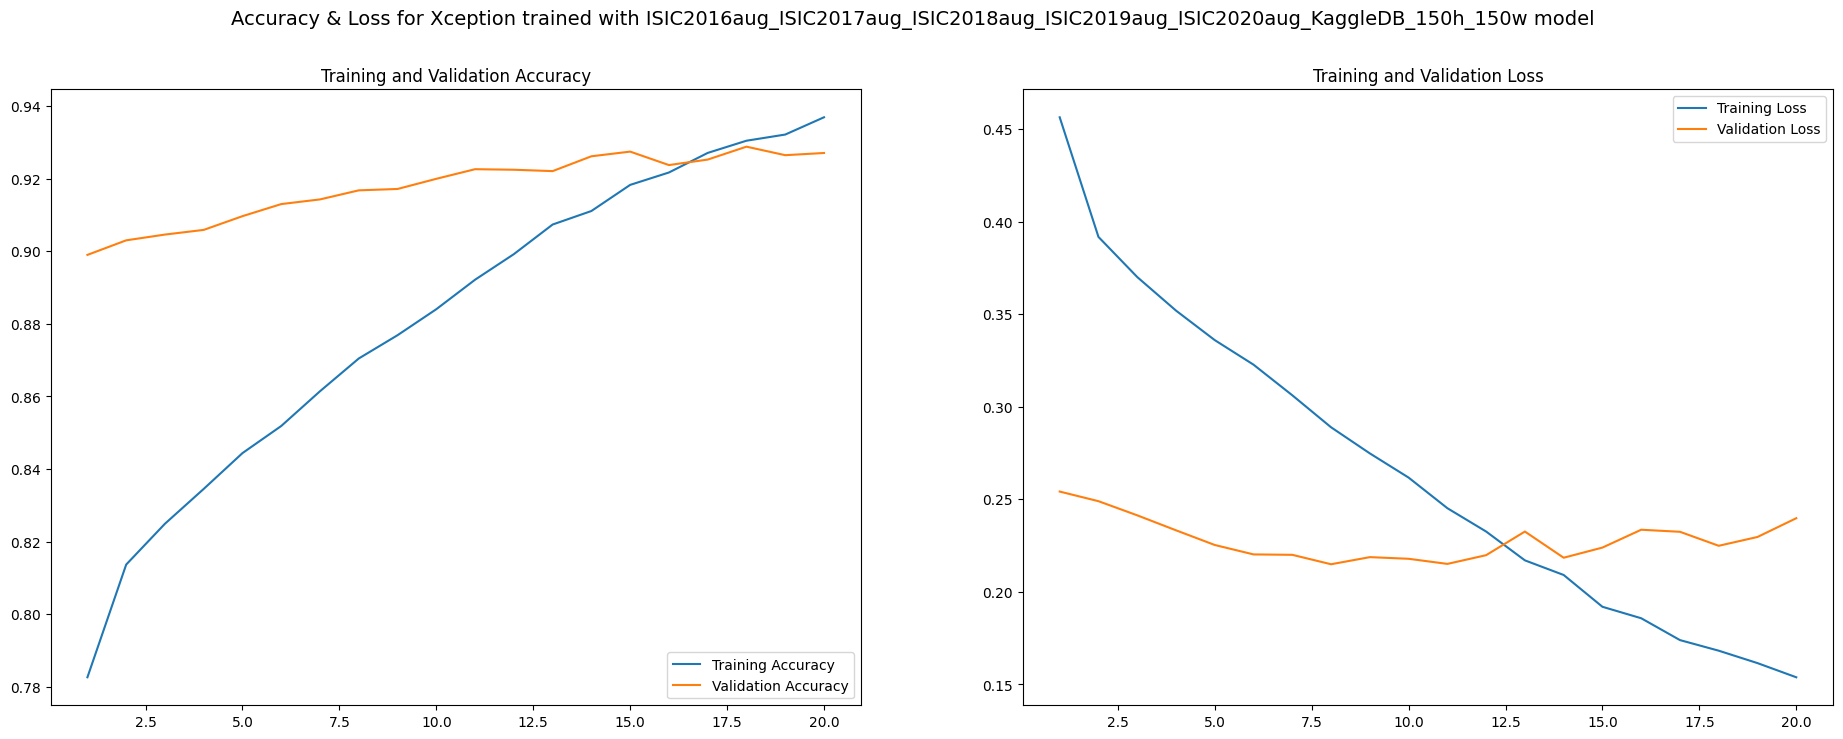

Testing on Kaggle DB
Evaluating Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model...



52/52 [==============================] - 1s 17ms/step - loss: 0.3140 - accuracy: 0.8497
Train loss = 0.3139769732952118  ;  Train accuracy = 84.97%

32/32 [==============================] - 1s 17ms/step - loss: 0.5233 - accuracy: 0.7730
Validation loss = 0.5232911109924316  ;  Validation accuracy = 77.30%

21/21 [==============================] - 0s 17ms/step - loss: 0.4944 - accuracy: 0.7682
Test loss = 0.4944223165512085  ;  Test accuracy = 76.82%
Computing predictions for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w...
Model report for Testing Kaggle DB on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.79      1.00      0.88       903
   Malignant       0.99      0.67      0.80       734

    accuracy                           0.85      1637
   macro av

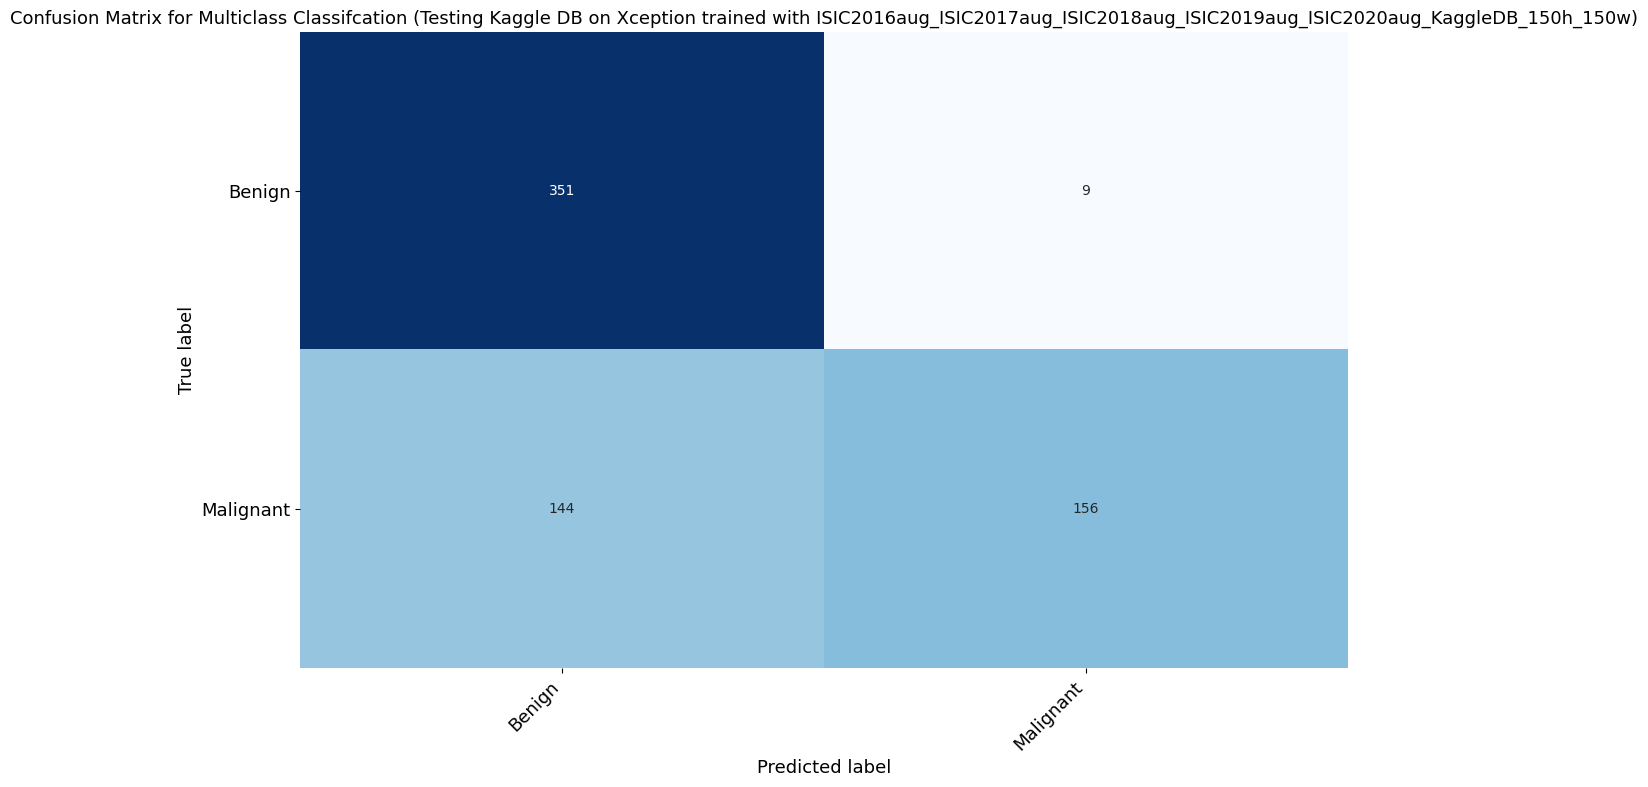

Testing on HAM10000
Evaluating Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model...



251/251 [==============================] - 5s 16ms/step - loss: 0.1770 - accuracy: 0.9360
Train loss = 0.17704065144062042  ;  Train accuracy = 93.60%

28/28 [==============================] - 0s 16ms/step - loss: 0.0896 - accuracy: 0.9672
Validation loss = 0.0896361693739891  ;  Validation accuracy = 96.72%

35/35 [==============================] - 1s 16ms/step - loss: 0.0876 - accuracy: 0.9728
Test loss = 0.08763717114925385  ;  Test accuracy = 97.28%
Computing predictions for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w...
Model report for Testing HAM10000 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.95      0.98      0.96      6994
   Malignant       0.83      0.63      0.72      1035

    accuracy                           0.94      8029
   macro 

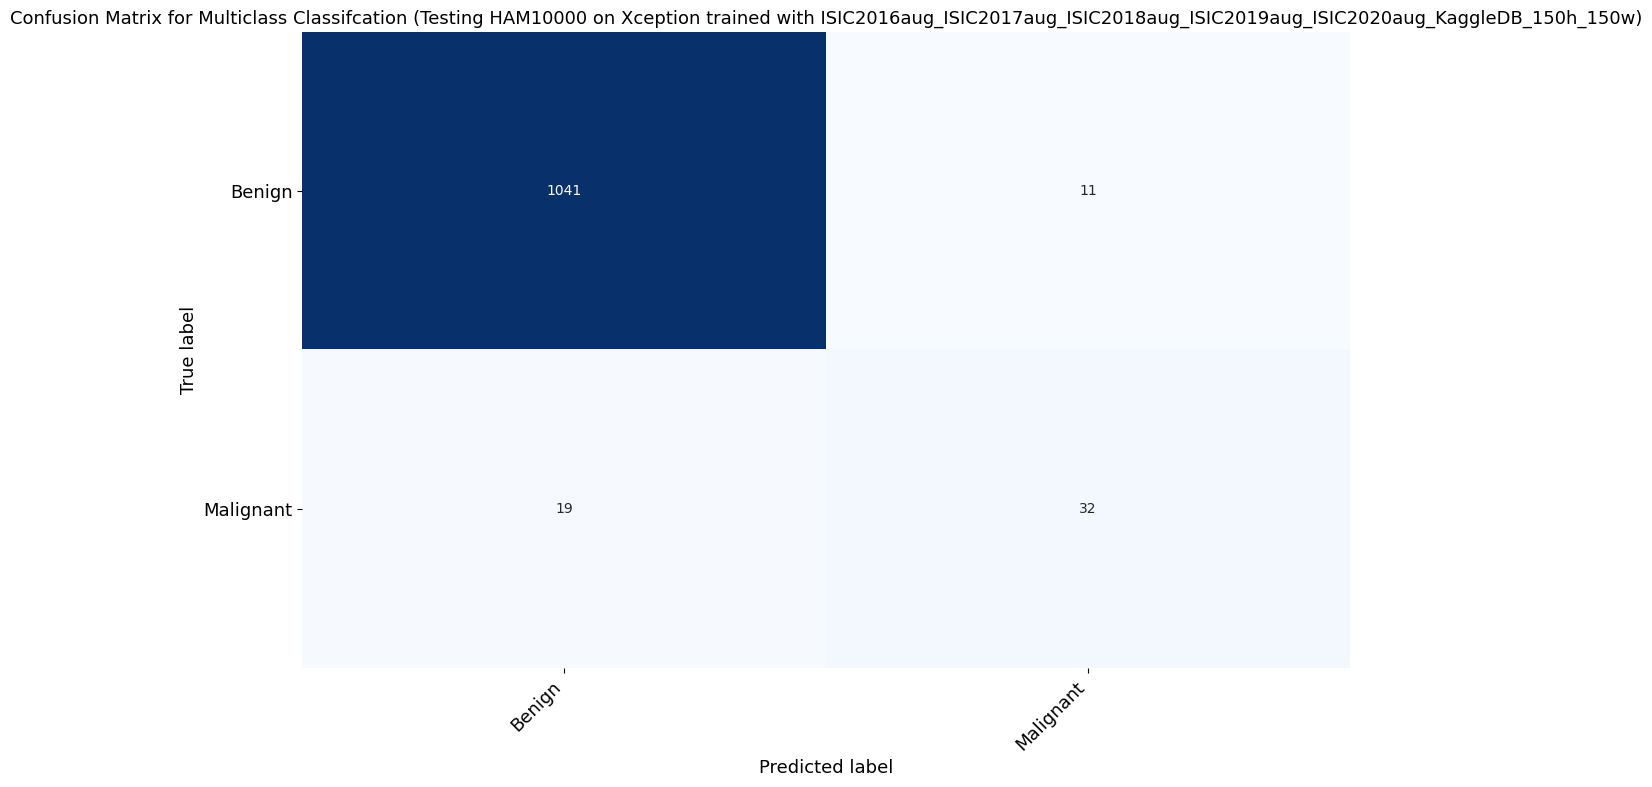

Testing on ISIC2016
Evaluating Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model...



23/23 [==============================] - 1s 16ms/step - loss: 0.2091 - accuracy: 0.9153
Train loss = 0.20906203985214233  ;  Train accuracy = 91.53%

6/6 [==============================] - 0s 15ms/step - loss: 0.2728 - accuracy: 0.8944
Validation loss = 0.27279341220855713  ;  Validation accuracy = 89.44%

12/12 [==============================] - 0s 15ms/step - loss: 0.2897 - accuracy: 0.8865
Test loss = 0.2897110879421234  ;  Test accuracy = 88.65%
Computing predictions for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w...
Model report for Testing ISIC2016 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.92      0.98      0.95       583
   Malignant       0.90      0.62      0.74       137

    accuracy                           0.92       720
   macro avg 

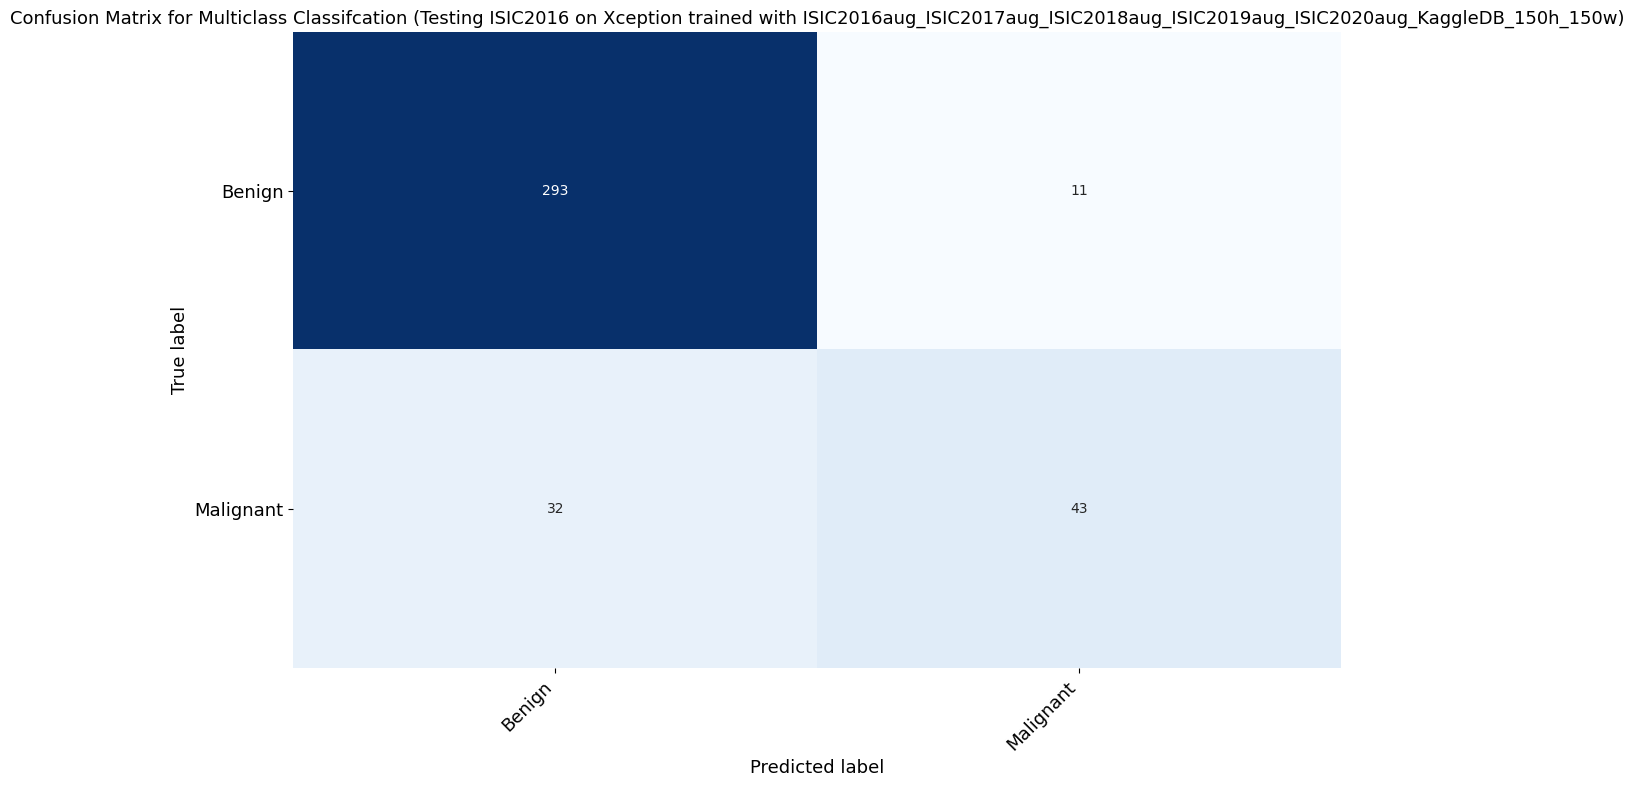

Testing on ISIC2017
Evaluating Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model...



63/63 [==============================] - 2s 16ms/step - loss: 0.2259 - accuracy: 0.9130
Train loss = 0.22589488327503204  ;  Train accuracy = 91.30%

5/5 [==============================] - 0s 15ms/step - loss: 0.3420 - accuracy: 0.8800
Validation loss = 0.34199216961860657  ;  Validation accuracy = 88.00%

19/19 [==============================] - 0s 16ms/step - loss: 0.2895 - accuracy: 0.8800
Test loss = 0.28946951031684875  ;  Test accuracy = 88.00%
Computing predictions for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w...
Model report for Testing ISIC2017 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.92      0.97      0.95      1626
   Malignant       0.85      0.65      0.74       374

    accuracy                           0.91      2000
   macro avg

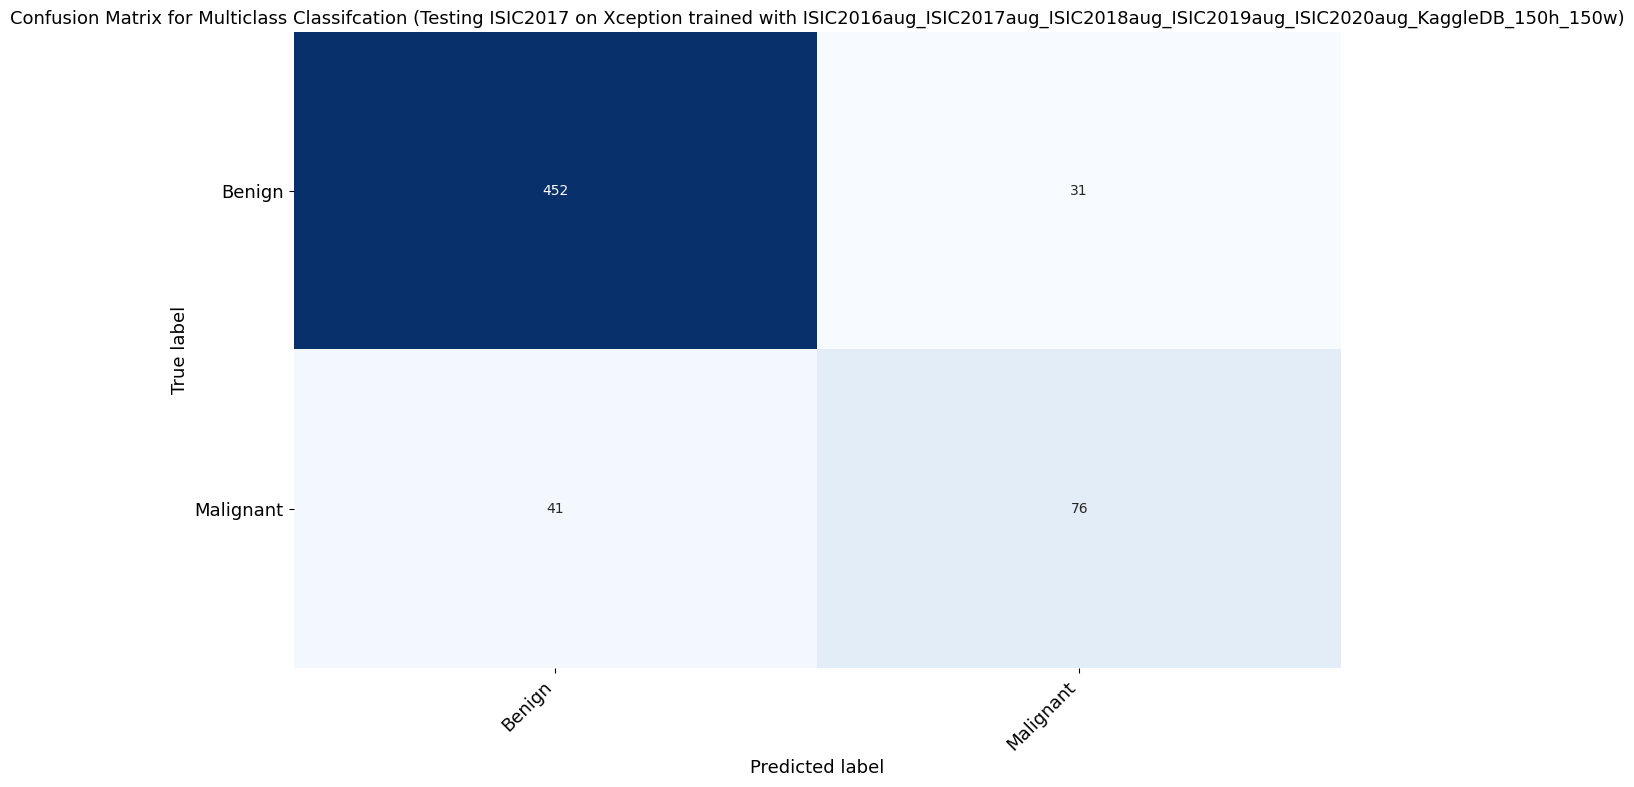

Testing on ISIC2018
Evaluating Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model...



313/313 [==============================] - 6s 16ms/step - loss: 0.1595 - accuracy: 0.9428
Train loss = 0.15948793292045593  ;  Train accuracy = 94.28%

7/7 [==============================] - 0s 14ms/step - loss: 0.3344 - accuracy: 0.8756
Validation loss = 0.33437854051589966  ;  Validation accuracy = 87.56%

48/48 [==============================] - 1s 16ms/step - loss: 0.3411 - accuracy: 0.8624
Test loss = 0.3410930037498474  ;  Test accuracy = 86.24%
Computing predictions for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w...
Model report for Testing ISIC2018 on Xception trained with ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w model ->


Train Report :
               precision    recall  f1-score   support

      Benign       0.95      0.98      0.97      8902
   Malignant       0.82      0.62      0.71      1113

    accuracy                           0.94     10015
   macro av

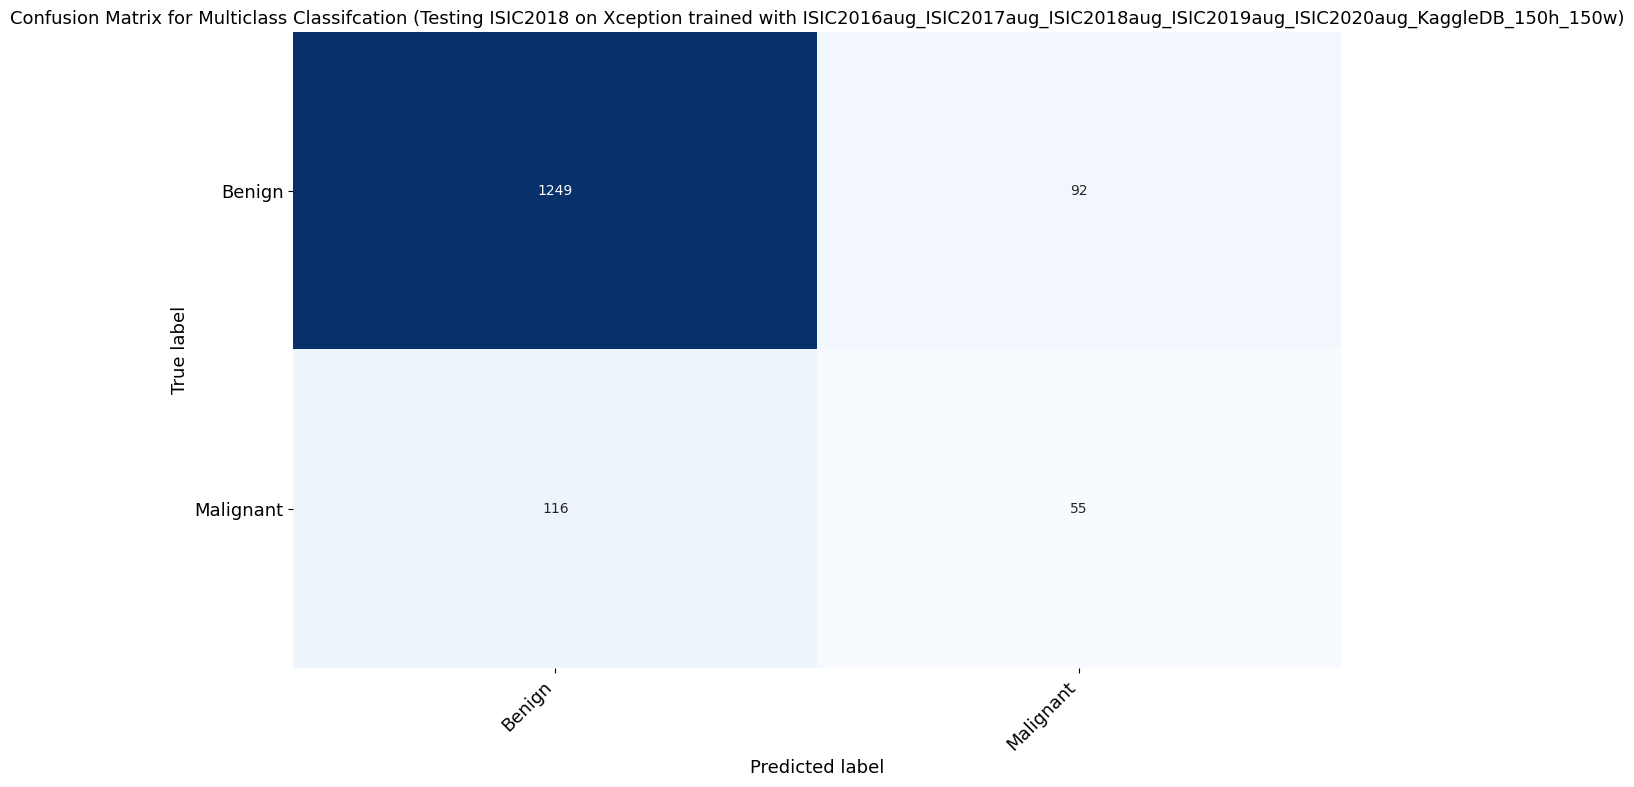

In [18]:
# Training ISIC2016aug+ISIC2017aug+ISIC2018aug+ISIC2019aug+ISIC2020aug+KaggleDB with Xception
networkType = mel.NetworkType.Xception

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'
picklename = 'ISIC2016aug_ISIC2017aug_ISIC2018aug_ISIC2019aug_ISIC2020aug_KaggleDB_150h_150w'
del_augmentation = {'ROTATION_RANGE':0.0, 'ZOOM_RANGE':0.0, 'HSHIFT_RANGE':0.0, 'WSHIFT_RANGE':0.0}
CFG.update(del_augmentation)

trainimages, testimages, validationimages, \
			trainlabels, testlabels, validationlabels, num_classes\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+picklename+'.pkl')

base_model = mel.CNN(CFG=CFG)
model_name = f'{networkType.name} trained with ' + picklename
model = base_model.xception()

history = base_model.fit_model(    
    model = model,
    model_name = model_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
)

visualizer = mel.Visualizer()
visualizer.visualize_model(model = model, model_name = model_name)

visualizer.visualize_performance(
    model_name = model_name,
    history = history
)


filename = model_name + '.hdf5' # self augmented
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename

dbpath = f'/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/{networkType.name}'

dbpath_KaggleDB = dbpath+'/'+f'KaggleDB_{img_size[0]}h_{img_size[1]}w.pkl'
dbpath_HAM10000 = dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2016 = dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2017 = dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl'
dbpath_ISIC2018 = dbpath+'/'+f'ISIC2018_{img_size[0]}h_{img_size[1]}w_binary.pkl'

base_model.evaluate_model_onAll(model_name, modelpath, dbpath_KaggleDB, dbpath_HAM10000, dbpath_ISIC2016, dbpath_ISIC2017, dbpath_ISIC2018)

